# MD demographics and precipitation event analysis

Software written by Prof. Maria J. Molina.

Analysis in collaboration with Prof. Sumant Nigam, Prof. Jon Poterjoy, and State Climatologist Alfredo Ruiz-Barradas.

Demographic data sources:

- https://data.census.gov/

- https://data.imap.maryland.gov/datasets/maryland::maryland-census-boundaries-census-block-groups-2020/about 

- https://data.imap.maryland.gov/datasets/maryland::maryland-census-data-zip-code-tabulation-areas-zctas/about 

- https://data.imap.maryland.gov/datasets/maryland::maryland-american-community-survey-acs-zip-code-tabulation-areas-zctas/about

- https://agnr.umd.edu/research/research-and-education-centers-locations

In [1]:
# import python packages
import warnings
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# ignoring shapely future warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
# function for later scaling
def minmaxscale(array):
    """
    Min-max scaling of data
    """
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

## Load tabular data

- locations of higher education, research centers, etc. in MD

- storm events

- 2016-2020 ACS total population estimates

In [4]:
# storm report data
svstorms = pd.read_csv('/Users/molina/Desktop/tstorms_md_jan2019-jul2022.csv')
svstorms = svstorms[
    (pd.to_datetime(svstorms['BEGIN_DATE']).dt.month >= 4) & (
        pd.to_datetime(svstorms['BEGIN_DATE']).dt.month <= 7)]

# edu and res centers
md_pb4yr = pd.read_csv('/Users/molina/Desktop/MD_Higher_Education_(Public_Four_Year).csv')
md_pb2yr = pd.read_csv('/Users/molina/Desktop/MD_Higher_Education_(Public_Two_Year).csv')
md_regio = pd.read_csv('/Users/molina/Desktop/MD_Higher_Education_(Regional_Education_Centers).csv')
md_envlb = pd.read_excel('/Users/molina/Desktop/md_env_lab.xlsx')
md_agres = pd.read_excel('/Users/molina/Desktop/agresearch.xlsx')

md_2020pop = pd.read_csv(
    '/Users/molina/Desktop/ACSDP5Y2020.DP05_2022-11-19T001636/ACSDP5Y2020.DP05-Data.csv', 
    header=0).drop(0).reset_index()

## Load shapefiles

- MD counties

- MD state

- demographics data (american community survey and census data)

In [5]:
# county shapefiles
md_counties = gpd.read_file('/Users/molina/Desktop/tl_2021_us_county/tl_2021_us_county.shp')
md_counties = md_counties.loc[md_counties['STATEFP']=='24']

# load state shapefiles
md_state = gpd.read_file('/Users/molina/Desktop/tl_2022_us_state/tl_2022_us_state.shp')
md_state = md_state[md_state['NAME'] == 'Maryland']

In [6]:
# load data from imap
md_zcta_census = gpd.read_file(
    '/Users/molina/Desktop/Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas_(ZCTAs)/DEMO_CensusDataZCTA_MDP.shp')
# print(md_zcta_census.crs)

# convert projection
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    md_zcta_census = md_zcta_census.to_crs({'init': 'epsg:4326'})
    # print(md_zcta_census.crs)

### Merging of data and creating new population variables

In [7]:
# total population
md_zcta_census['newpop'] = md_2020pop['DP05_0001E'].astype(float)

# margin of error (+/-)
md_zcta_census['newpop_merr'] = md_2020pop['DP05_0001M'].astype(float)

# compute population normalized by land area
md_zcta_census['popnormbyarea'] = md_zcta_census['newpop'] / (md_zcta_census['AREALAND'] / 1000)

# compute population normalized by land area
md_zcta_census['oldpopnormbyarea'] = md_zcta_census['POP100'] / (md_zcta_census['AREALAND'] / 1000)

### Load RMS and extreme events

- data provided by State Climatologist Alfredo Ruiz-Barradas in netCDF format

In [8]:
# precip data from state climatologist
ds_md_prp_std = xr.open_dataset(
    '/Users/molina/Desktop/precge2_wrms_count_nclimgridd_5x5_annual_1991-2020.nc', 
    decode_cf=False)

# slice data to only contain mid-atlantic region
ds_md_prp_std = ds_md_prp_std.sel(lon=slice(-80,-74), lat=slice(37,40)).isel(time=0)

# extract variables and mask invalid values
ds_rms = ds_md_prp_std['prcp2rms'].where(ds_md_prp_std['prcp2rms']!=-9.999000e+03)
ds_cnt = ds_md_prp_std['prcp2cnt'].where(ds_md_prp_std['prcp2rms']!=-9.999000e+03)

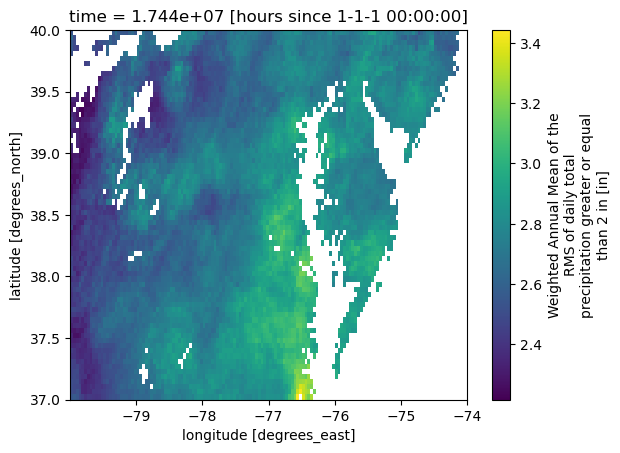

In [9]:
# quick visualization of RMS data
ds_rms.plot()

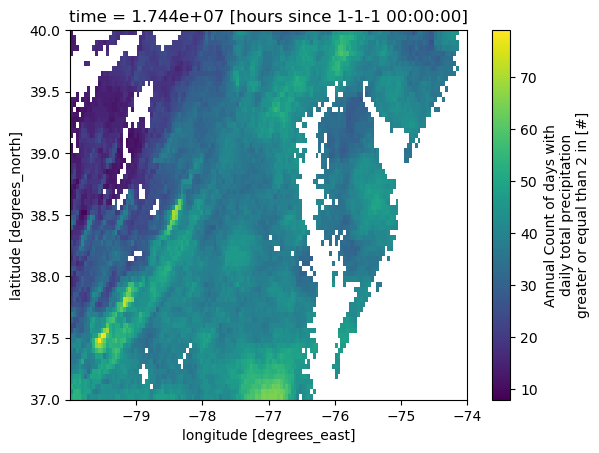

In [10]:
# quick visualization of event frequency data
ds_cnt.plot()

## Create state mask

In [11]:
# create state mask based on 5x5-km netcdf grid
md_state_mask = np.zeros(ds_rms.shape)

for i, j in product(range(ds_rms.lat.shape[0]), range(ds_rms.lon.shape[0])):
    
    # if the MD state shapefile contains that lat/lon value, assign value of 1, 
    # otherwise leave as zero
    if md_state.contains(Point(ds_rms.lon[j], ds_rms.lat[i])).values[0]:
        
        md_state_mask[i,j] = 1

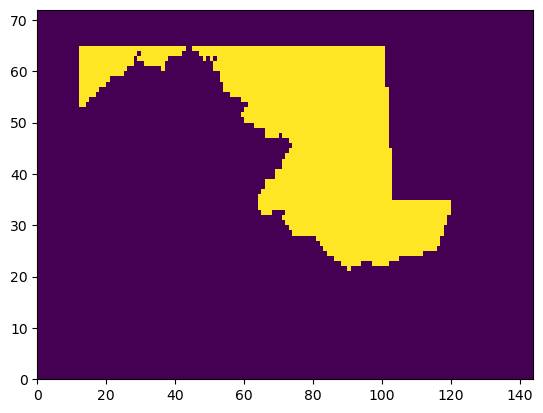

In [12]:
# visualize state mask
plt.pcolormesh(md_state_mask); plt.show()

## Regrid shapefile data for index creation

In [13]:
# gridded normalized population
# create new 2-d array
md_popnorm_grid = np.zeros((ds_cnt.shape[0], ds_cnt.shape[1]))

for i, j in product(range(ds_cnt.shape[0]), range(ds_cnt.shape[1])):
    
    # if that lat/lon is nan in netcdf grid, leave nan
    if np.isnan(ds_cnt[i,j].values):
        
        md_popnorm_grid[i,j] = np.nan
        
    # if that lat/lon is not nan, continue
    if ~np.isnan(ds_cnt[i,j].values):
        
        # check if that lat/lon is in a MD zip code
        for num, k in enumerate(md_zcta_census.contains(
            Point(ds_cnt.lon[j].values, ds_cnt.lat[i].values))):
            
            # if that lat/lon value is in MD zip code, 
            # input the respective normalize population in the new 2-d array
            if k:
                md_popnorm_grid[i,j] = md_zcta_census['popnormbyarea'].iloc[num]

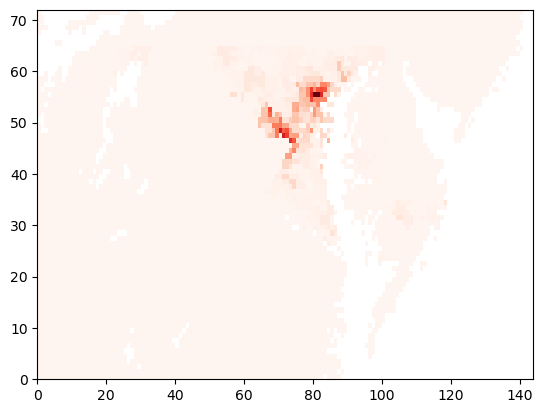

In [14]:
# visualize new 2-d array for normalize population
plt.pcolormesh(md_popnorm_grid, cmap='Reds', vmin=0, vmax=5); plt.show()

In [15]:
# take square root of pop density
md_popnorm_grid_sqrt = np.sqrt(md_popnorm_grid)

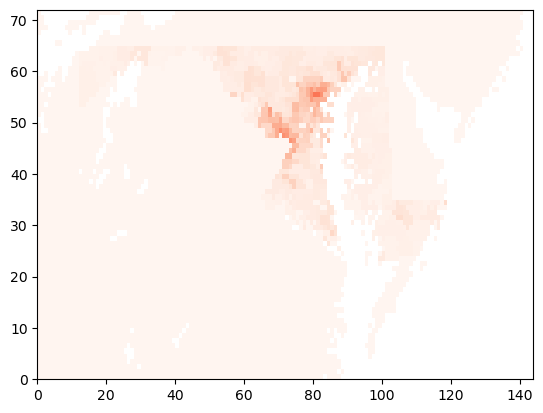

In [16]:
# visualize new 2-d array for normalize population
plt.pcolormesh(md_popnorm_grid_sqrt, cmap='Reds', vmin=0, vmax=5); plt.show()

## county mask for subsequent scaling of data

In [17]:
# index dictionary for mask
dict_md_counties = {}
for i, j in enumerate(md_counties['NAMELSAD'].astype(str).values):
    dict_md_counties[j] = i

# county mask (24 counties/city of Balt, lat, lon)
county_grid = np.zeros((md_counties['NAMELSAD'].astype(str).shape[0], ds_cnt.shape[0], ds_cnt.shape[1]))

# loop thru lat/lon points
for i, j in product(range(ds_cnt.shape[0]), range(ds_cnt.shape[1])):
    
    # if the grid point is nan in climate data, leave as nan
    if np.isnan(ds_cnt[i,j].values):
        
        county_grid[:,i,j] = np.nan
        
    # if not nan, continue here
    if ~np.isnan(ds_cnt[i,j].values):
        
        # check if point is in a county or city of Baltimore, if so, continue
        for num, k in enumerate(md_counties.contains(Point(ds_cnt.lon[j].values, ds_cnt.lat[i].values))):
            
            # add a value of 1 depending on which county/city it is (using dictionary)
            if k:
                county_grid[dict_md_counties[md_counties['NAMELSAD'].iloc[num]], i, j] = 1.0

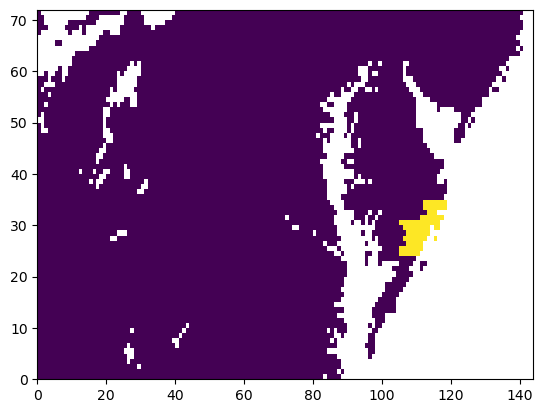

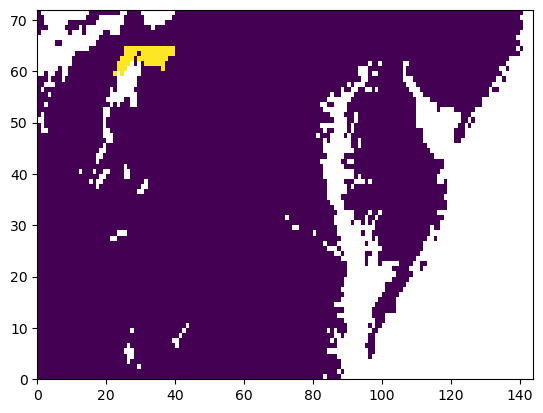

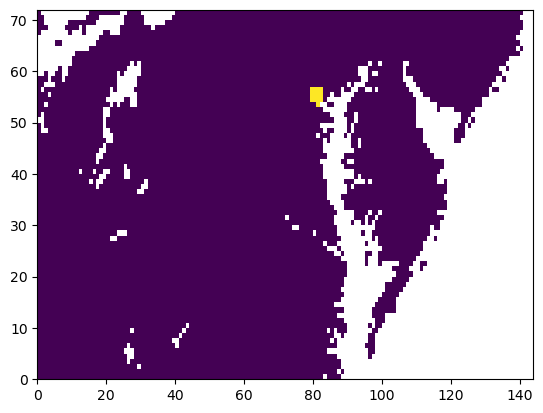

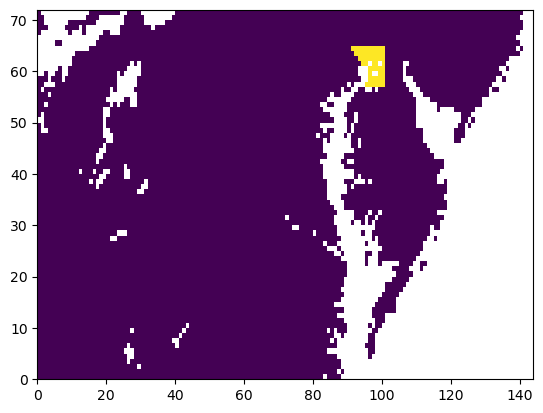

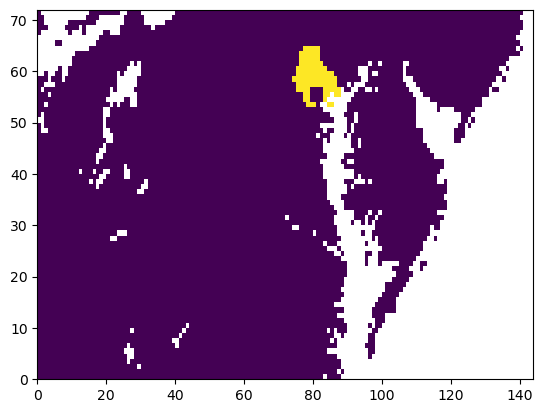

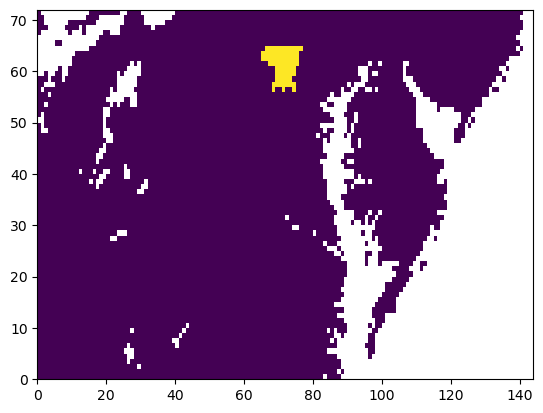

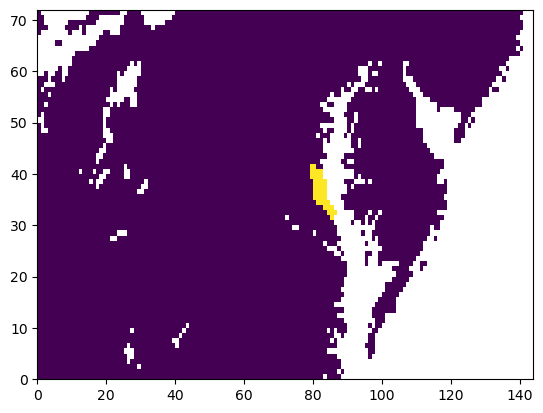

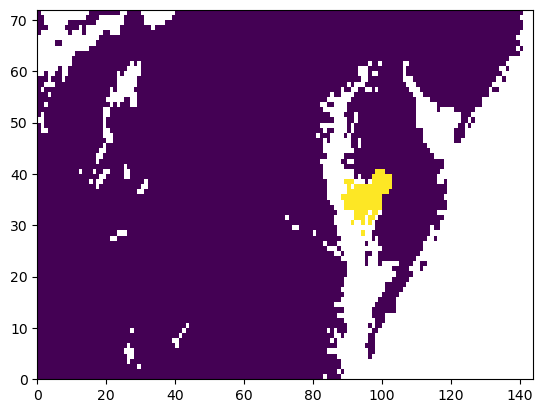

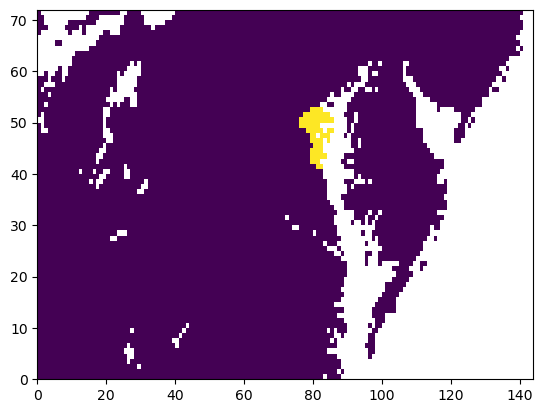

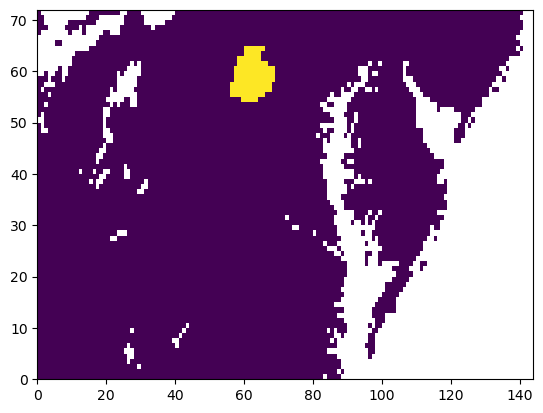

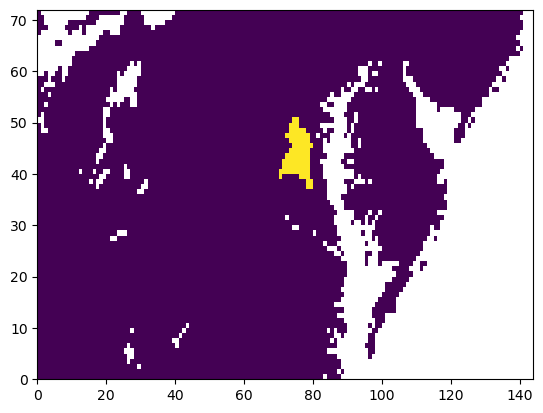

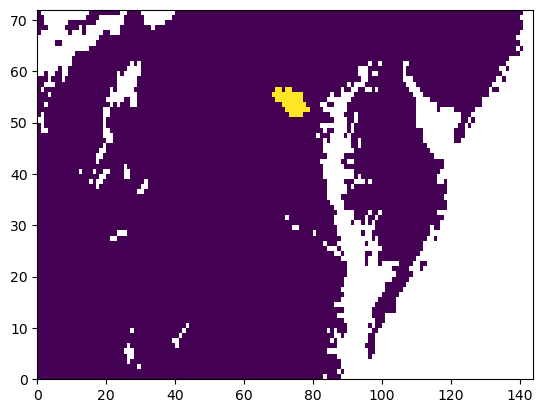

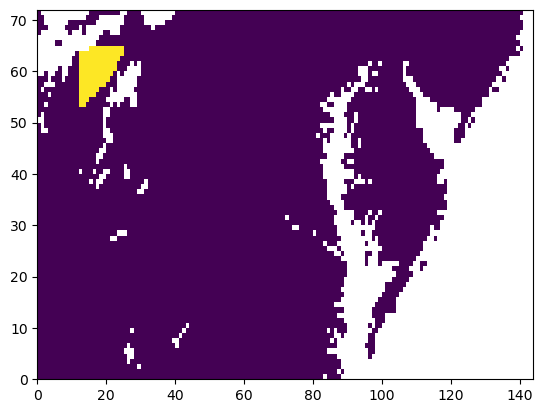

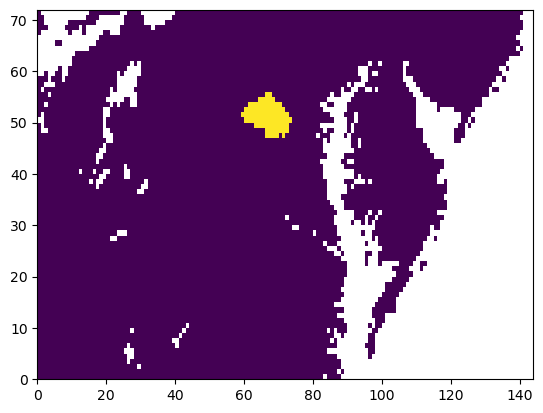

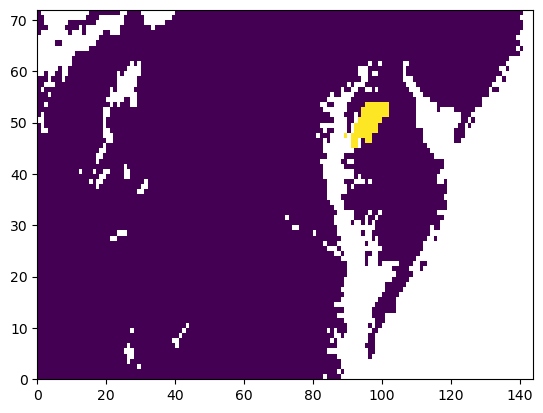

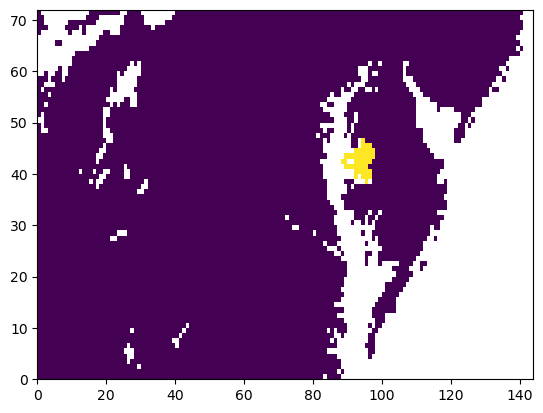

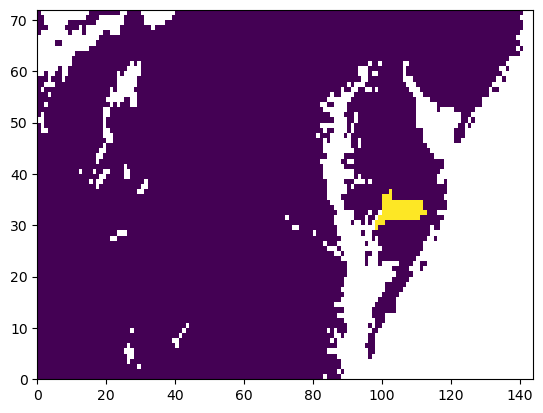

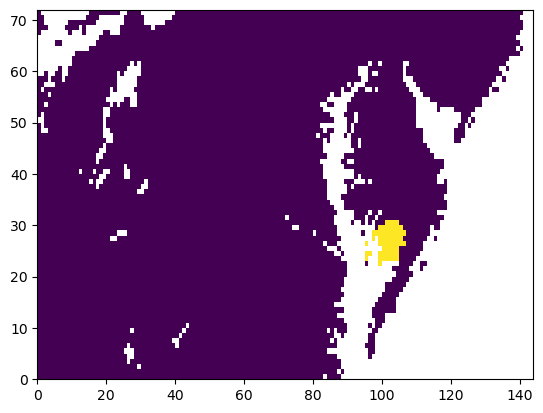

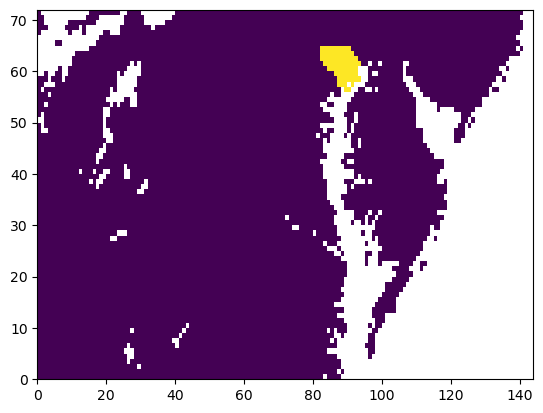

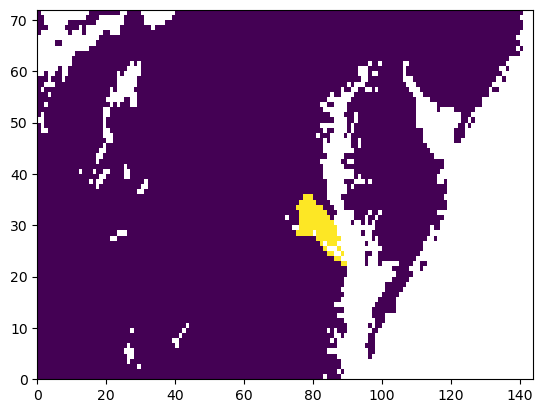

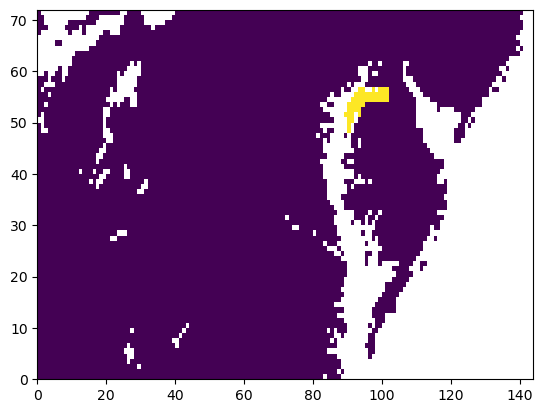

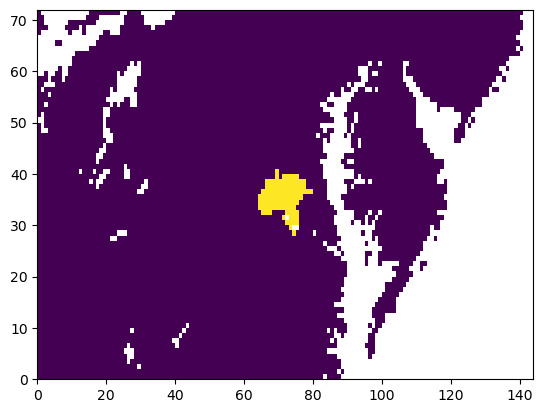

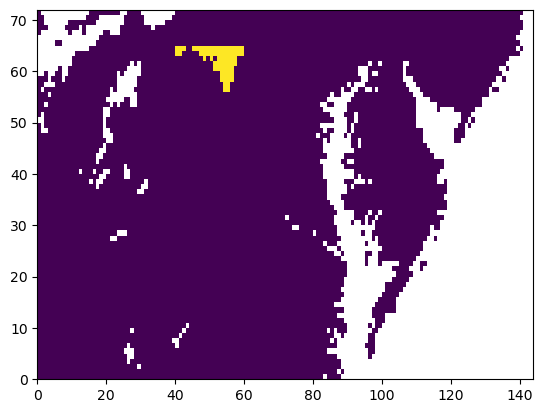

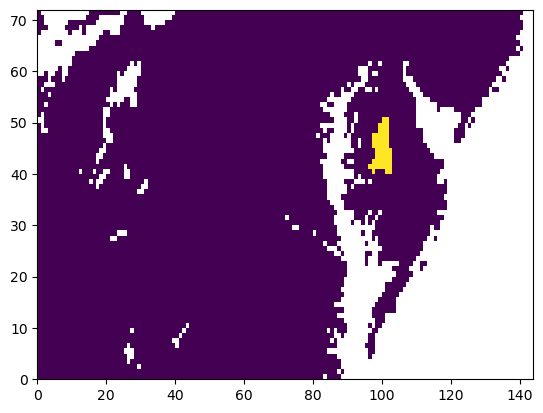

In [18]:
# visualize each county grid for sanity
for k in range(24):
    plt.pcolormesh(county_grid[k])
    plt.show()

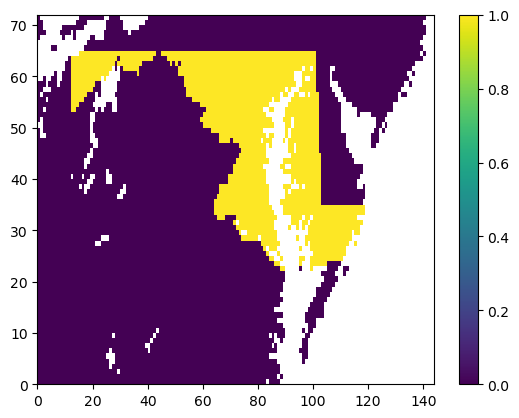

In [19]:
# another sanity check
# sum all counties and city of Balt, state of MD should all equal 1.0 if done correctly
test_grid = np.zeros((county_grid[0].shape[0], county_grid[0].shape[1]))

for k in range(24):
    test_grid = test_grid + county_grid[k]
    
cs = plt.pcolormesh(test_grid, cmap='viridis')
plt.colorbar(cs)
plt.show()

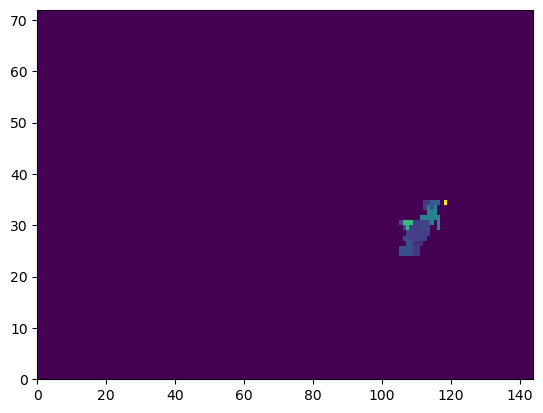

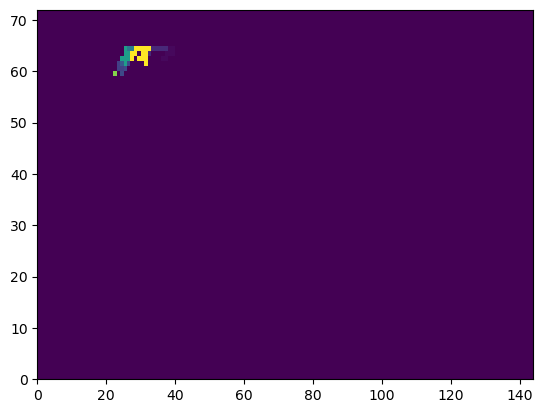

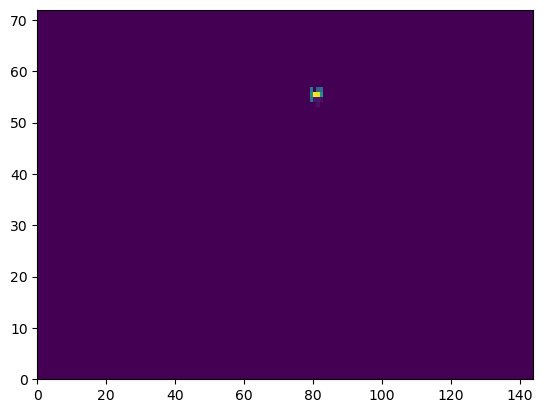

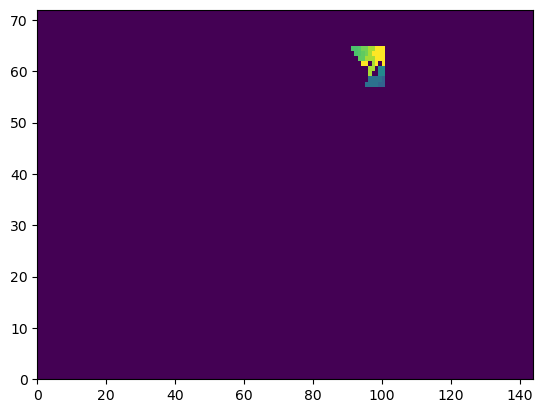

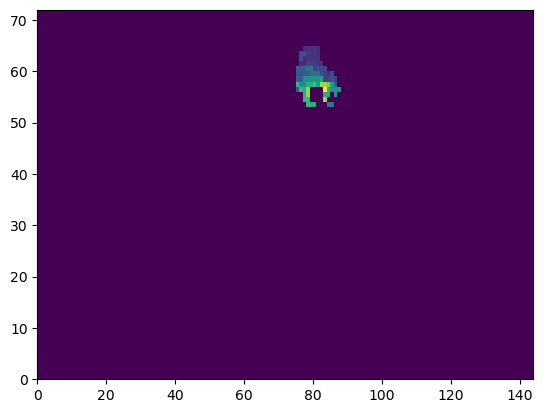

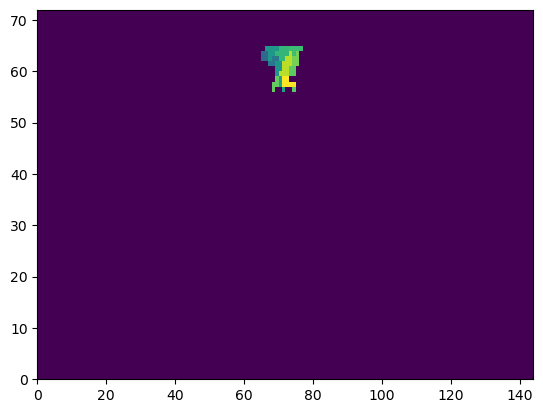

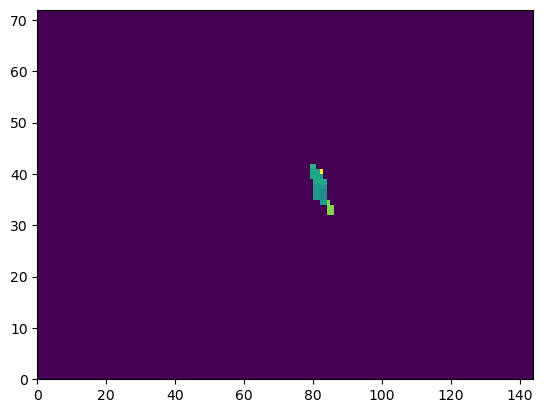

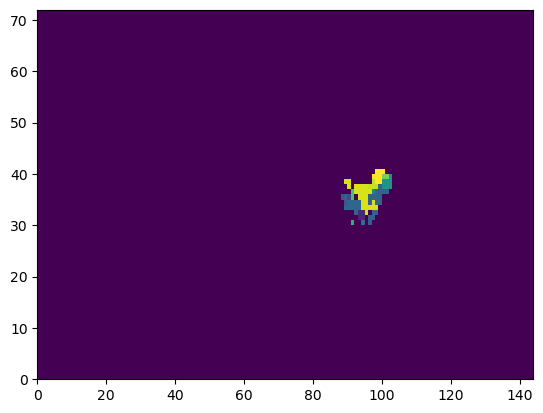

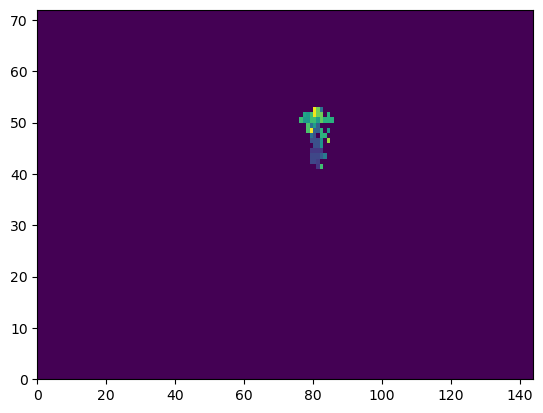

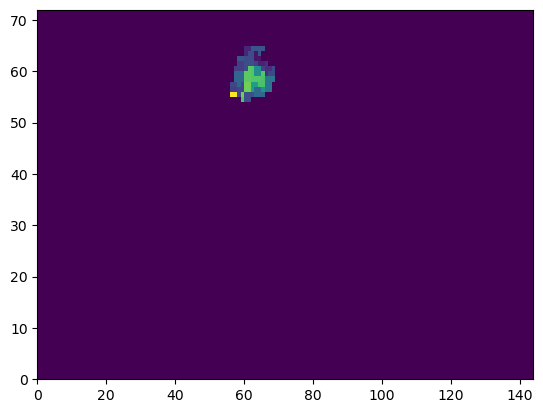

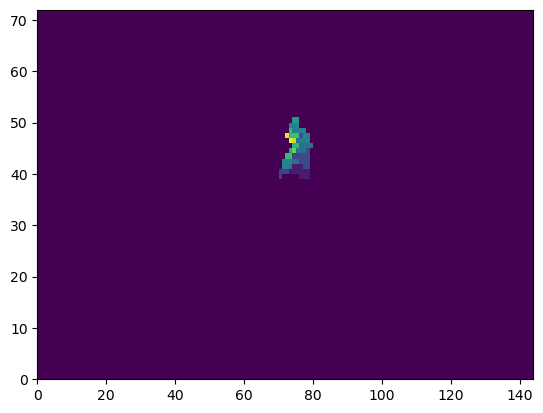

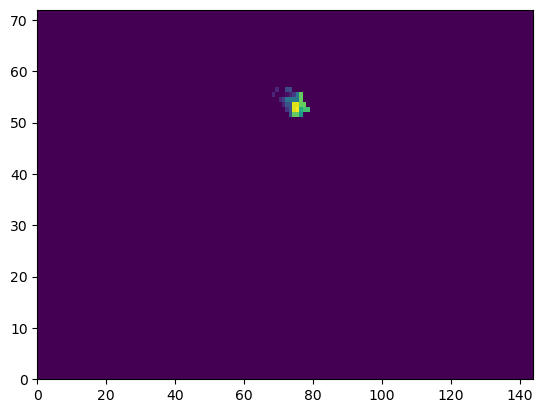

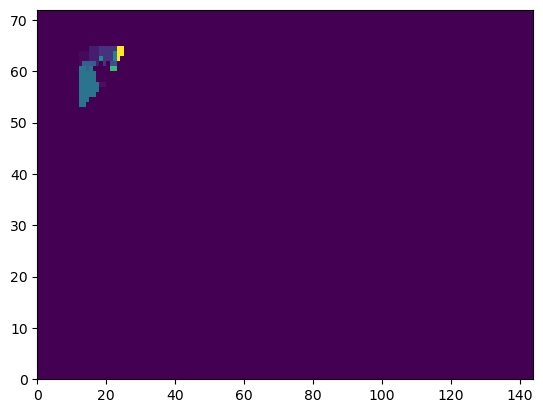

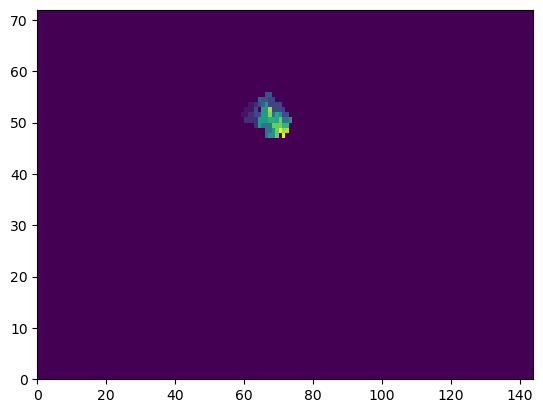

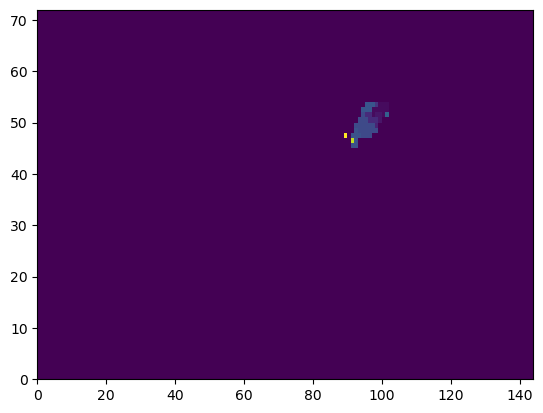

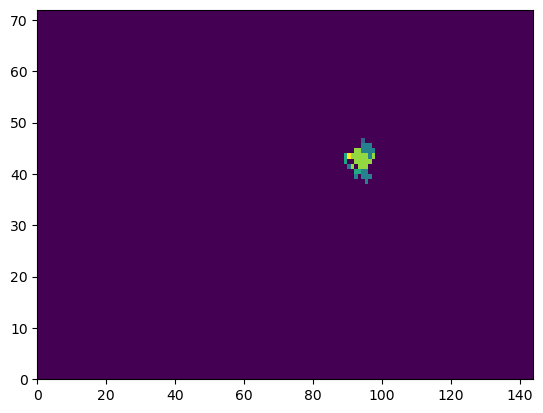

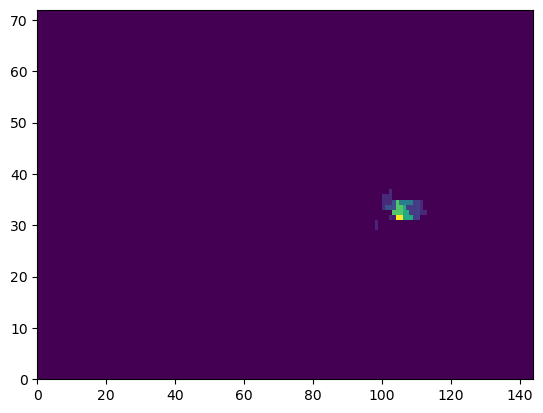

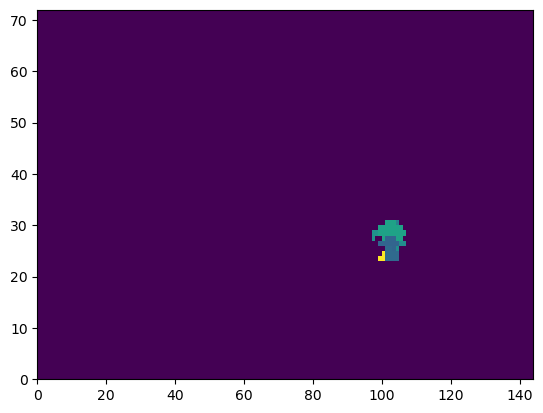

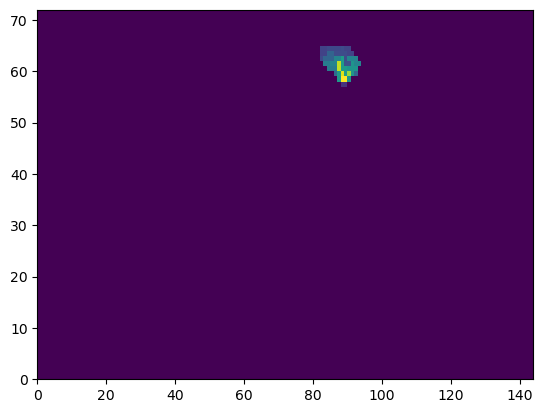

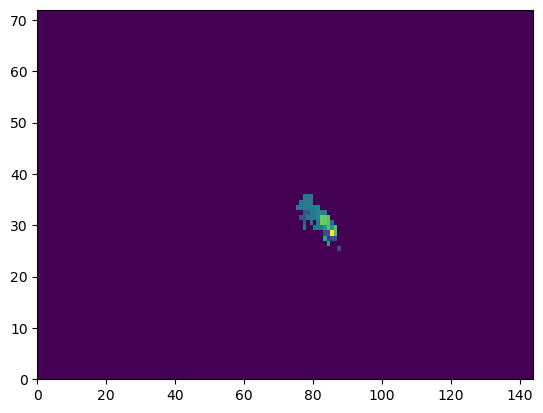

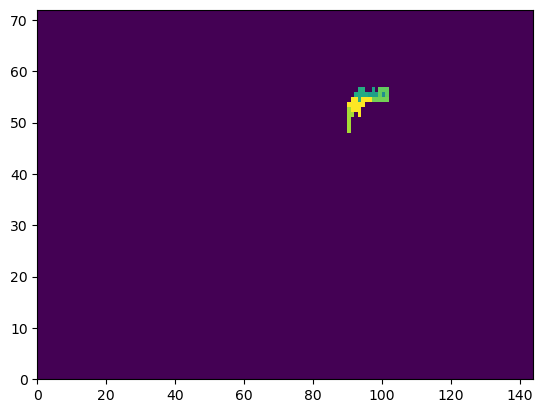

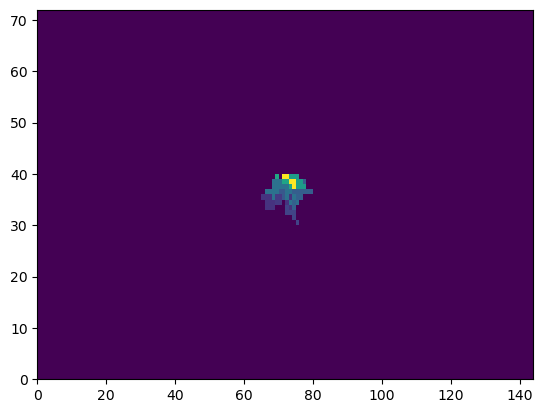

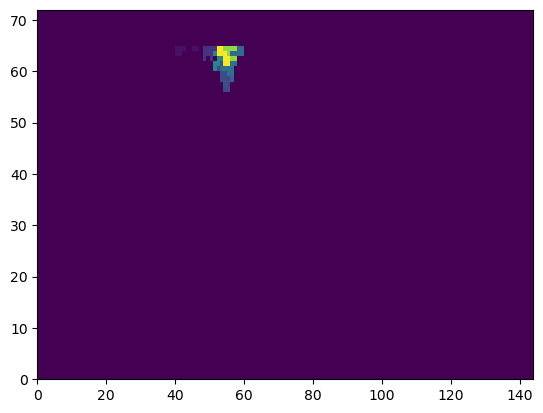

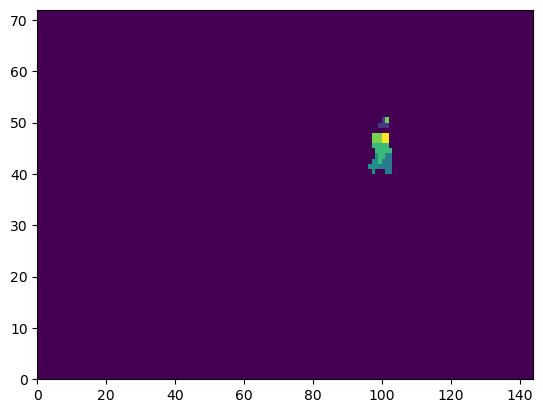

In [20]:
# create 2-d array for the index (event count)
county_popnorm_grid_sqrt = np.zeros((county_grid[0].shape[0], county_grid[0].shape[1]))

# loop thru all 24 counties/city
for r in range(24):
    
    # min-max scale each county/city:
    minmaxscaled_pop = minmaxscale(xr.where(county_grid[r]==1, md_popnorm_grid_sqrt, np.nan))
    minmaxscaled_pop = xr.where(~np.isnan(minmaxscaled_pop), minmaxscaled_pop, 0.0)
    
    # quick vis
    plt.pcolormesh(minmaxscaled_pop); plt.show()
    
    # fill the respective county/city array with index
    county_popnorm_grid_sqrt = county_popnorm_grid_sqrt + (minmaxscaled_pop)

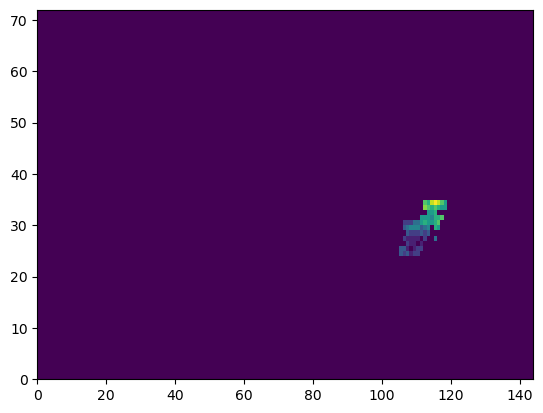

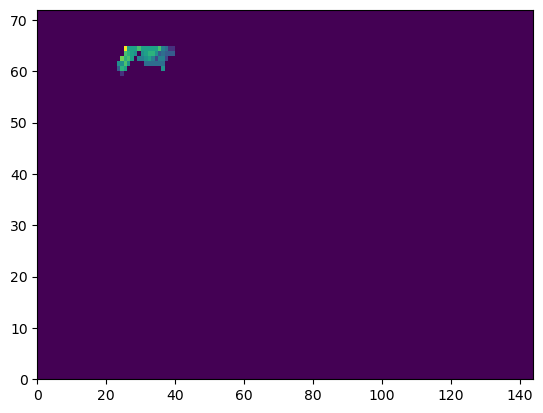

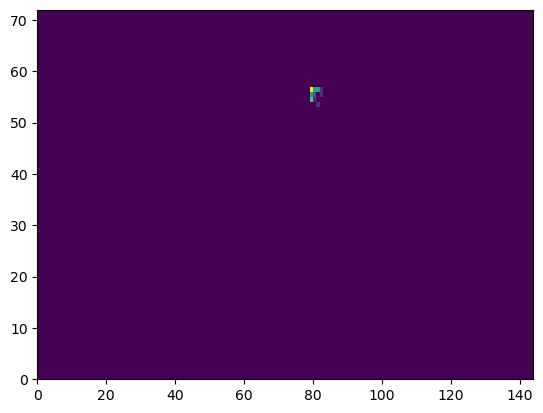

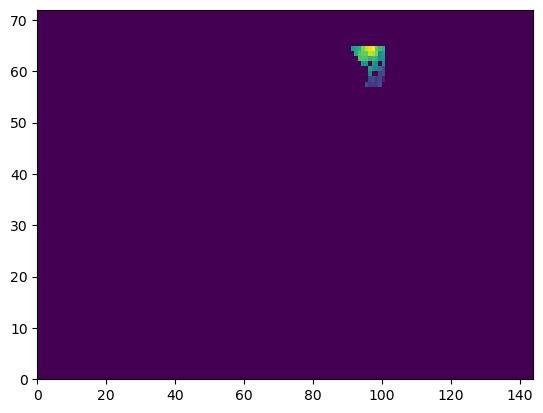

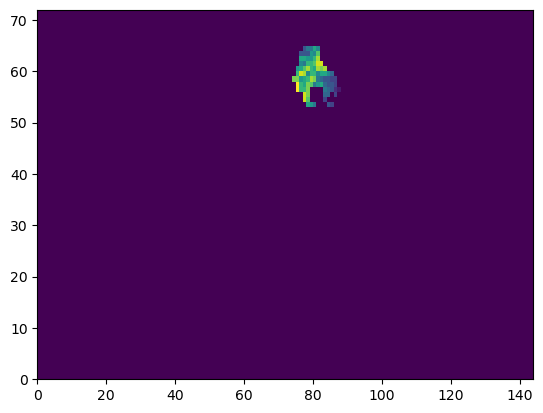

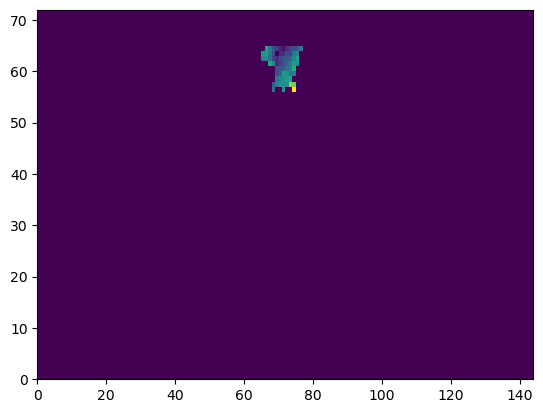

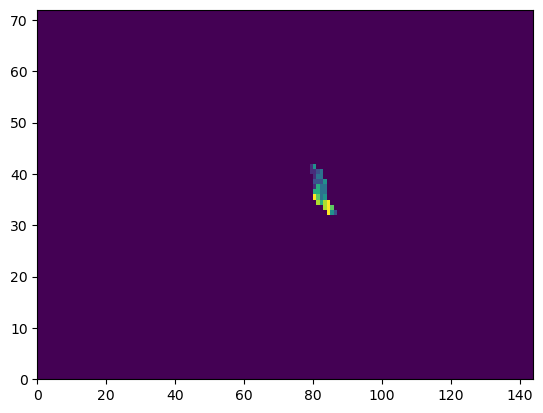

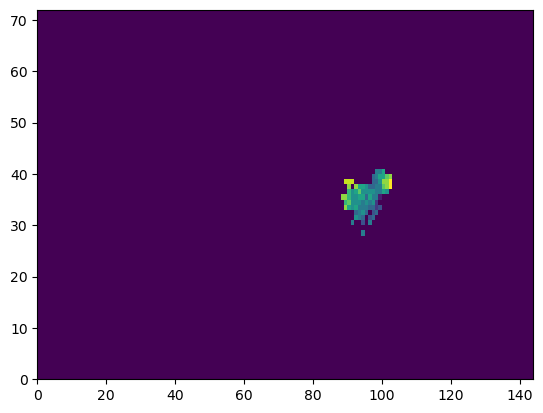

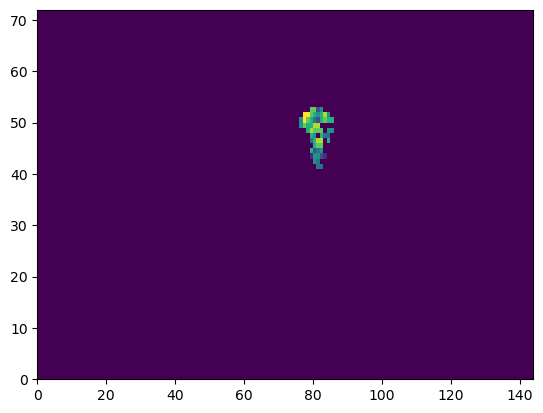

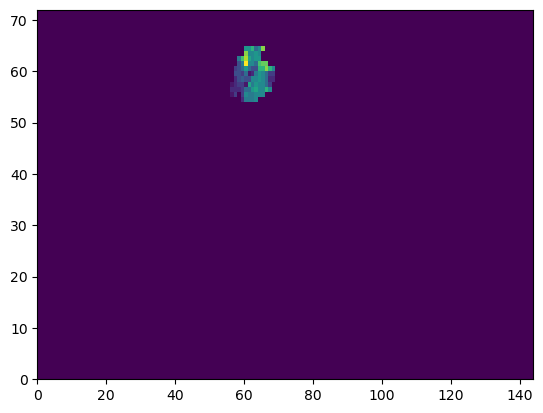

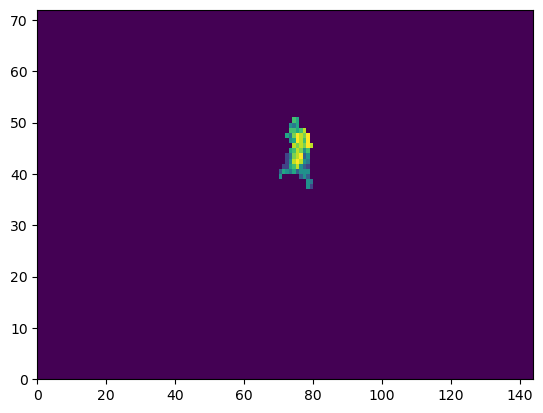

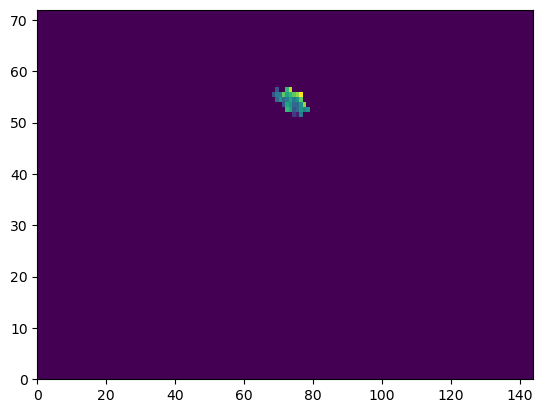

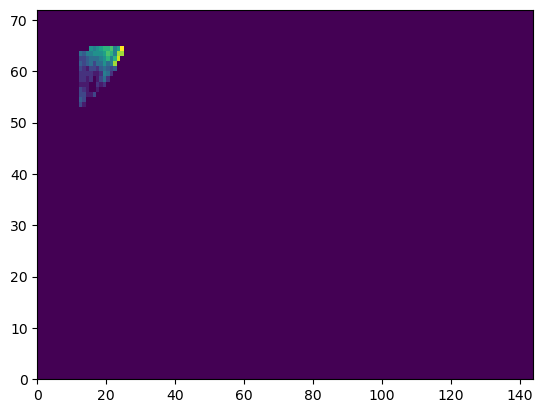

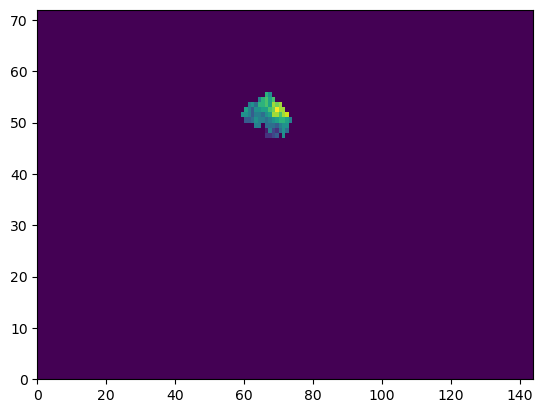

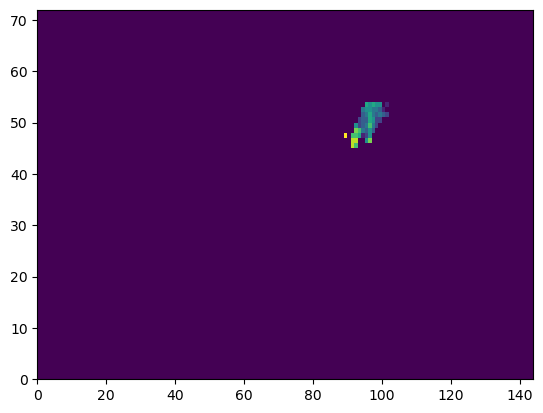

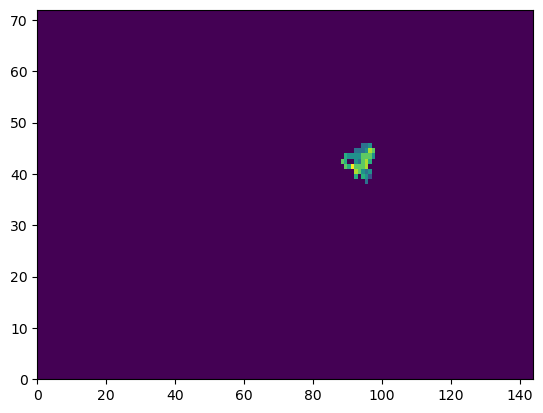

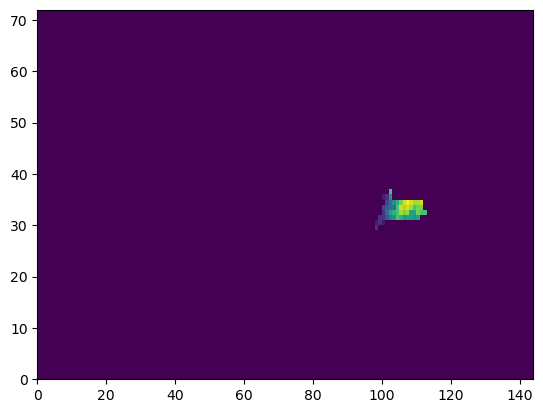

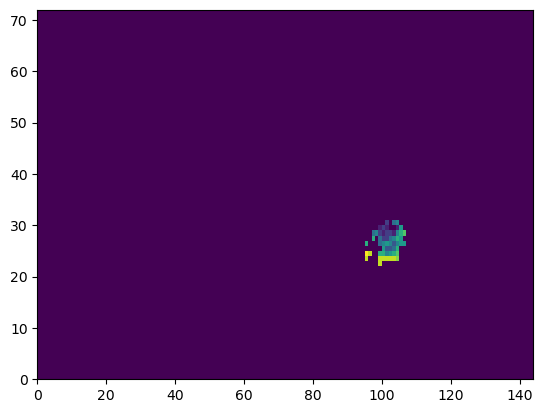

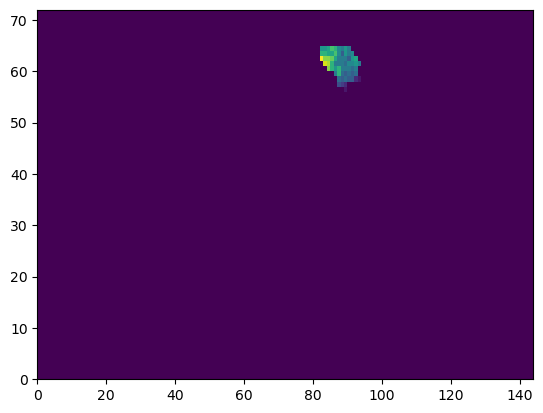

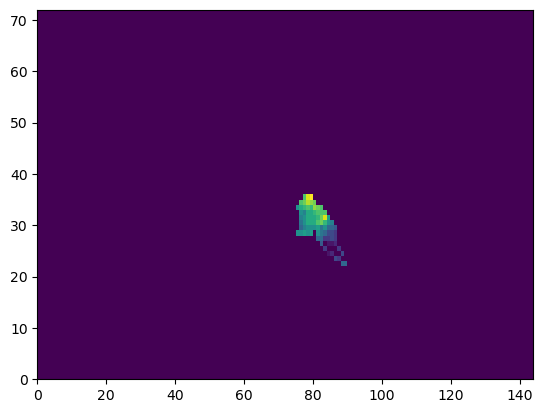

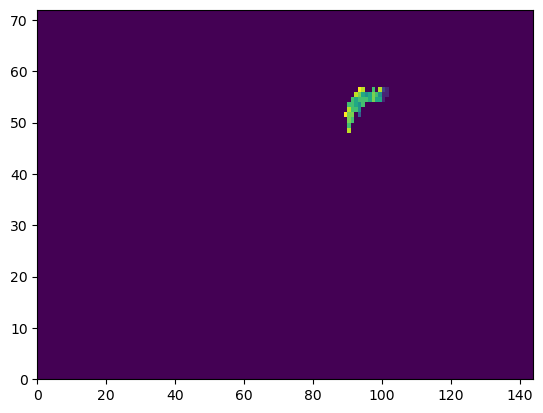

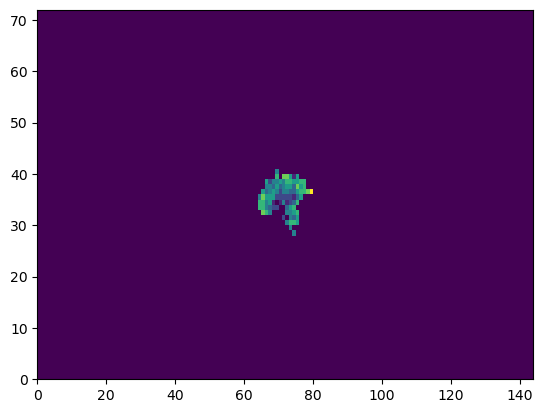

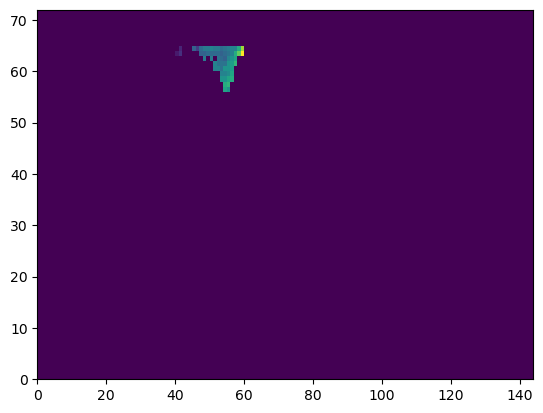

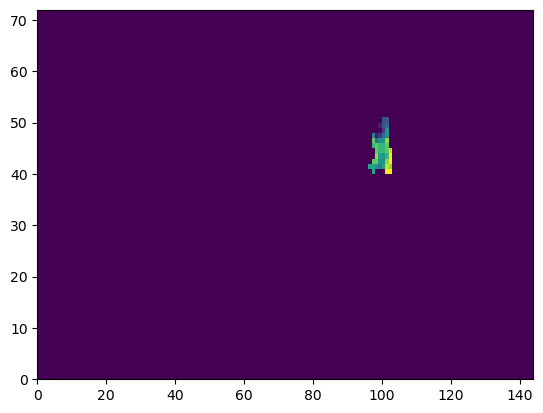

In [21]:
# create 2-d array for the index (event count)
county_weighted_index_cnt = np.zeros((county_grid[0].shape[0], county_grid[0].shape[1]))

# loop thru all 24 counties/city
for r in range(24):
    
    # min-max scale each county/city:
    # event frequency
    minmaxscaled_event = minmaxscale(ds_cnt.where(county_grid[r]==1, np.nan))
    minmaxscaled_event = minmaxscaled_event.where(~np.isnan(minmaxscaled_event), 0.0)
    
    # quick vis
    plt.pcolormesh(minmaxscaled_event); plt.show()
    
    # fill the respective county/city array with index
    county_weighted_index_cnt = county_weighted_index_cnt + (minmaxscaled_event)

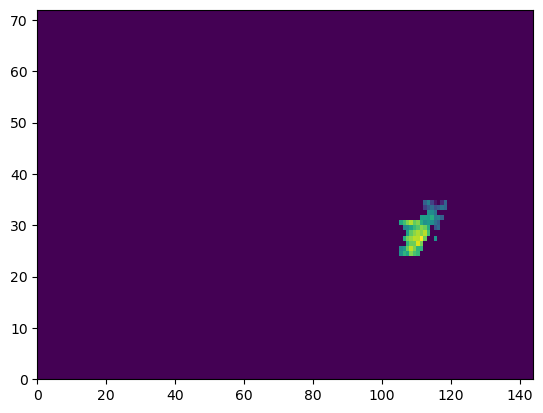

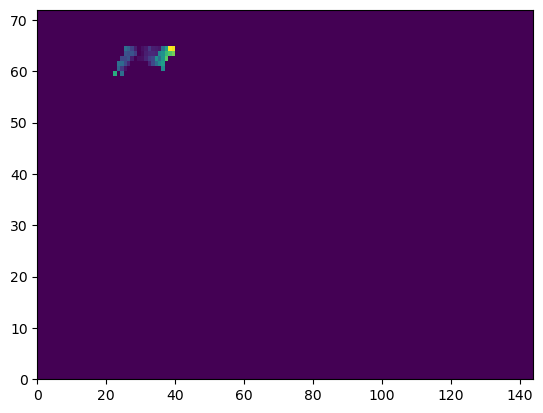

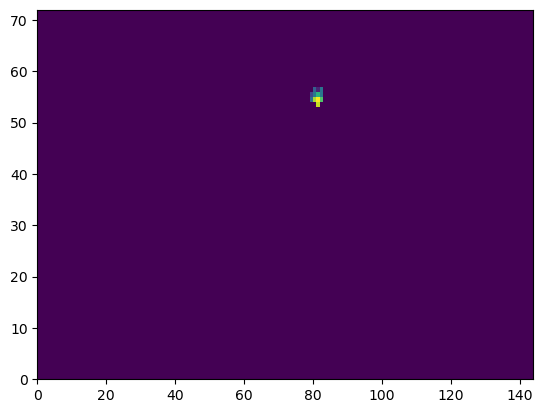

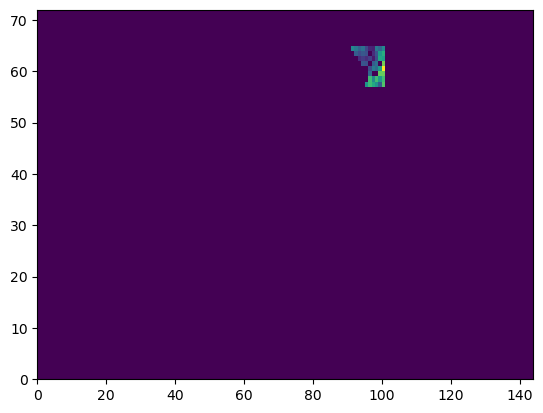

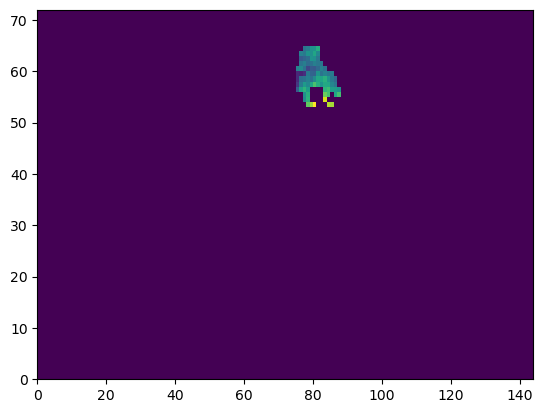

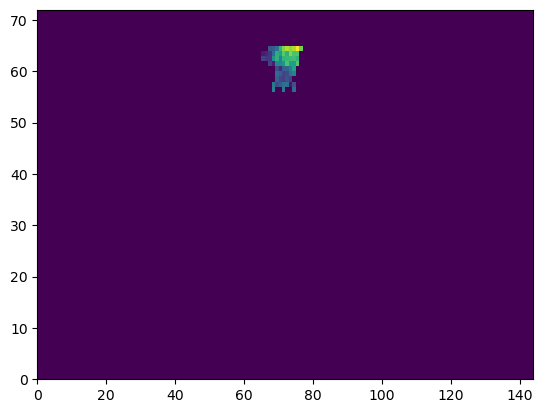

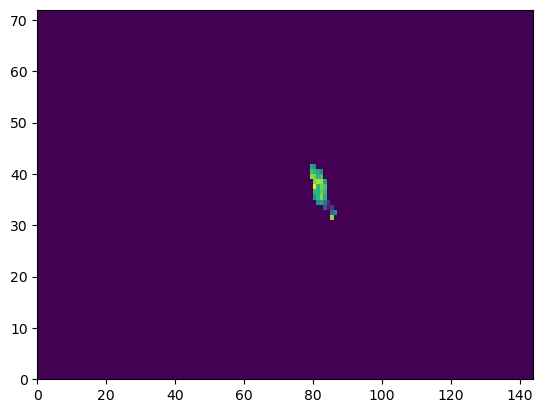

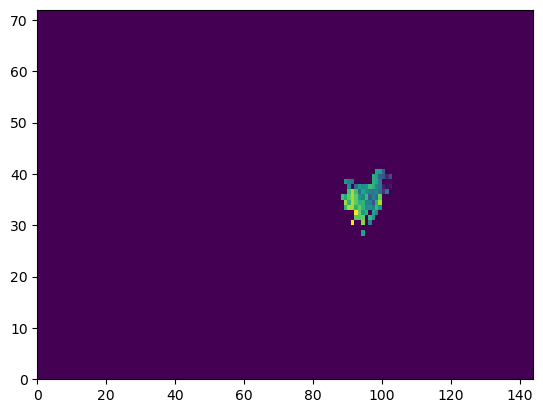

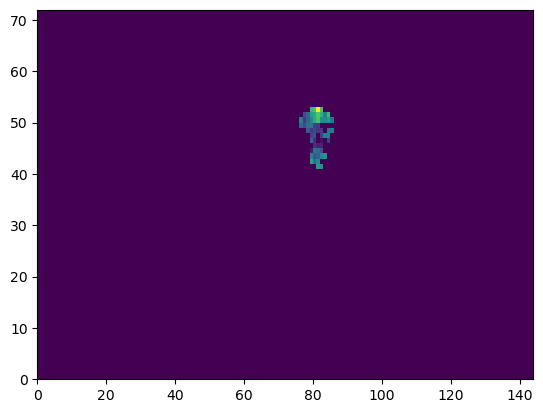

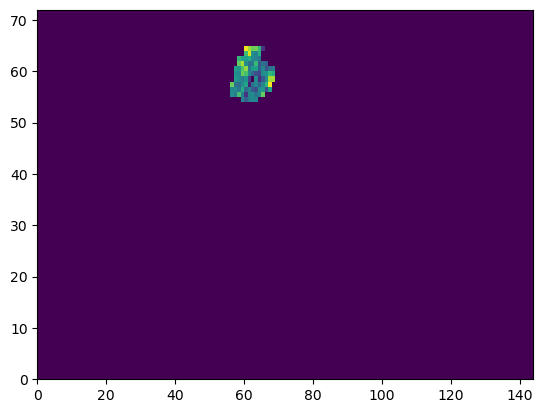

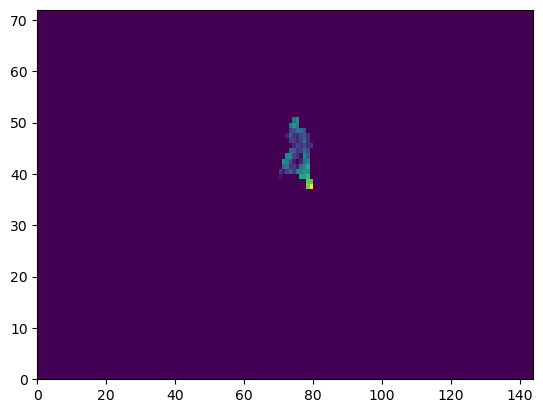

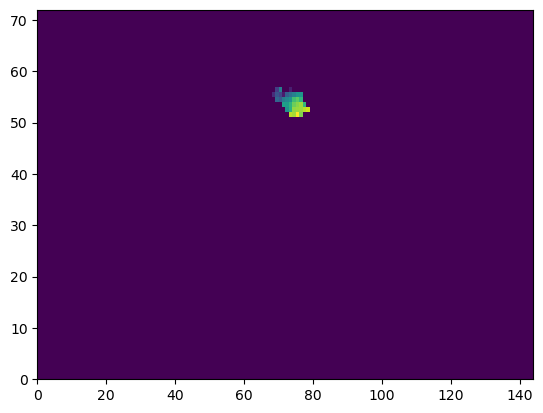

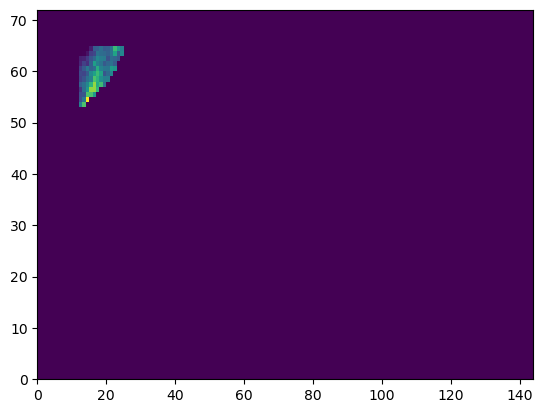

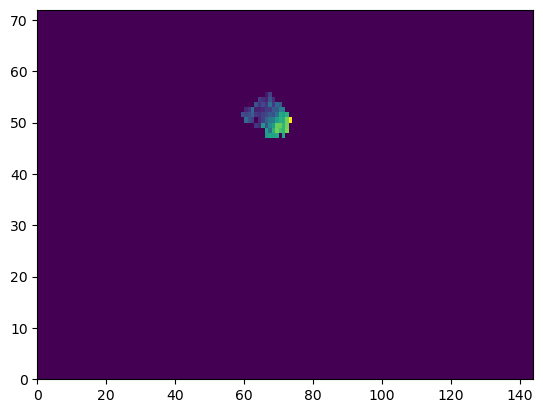

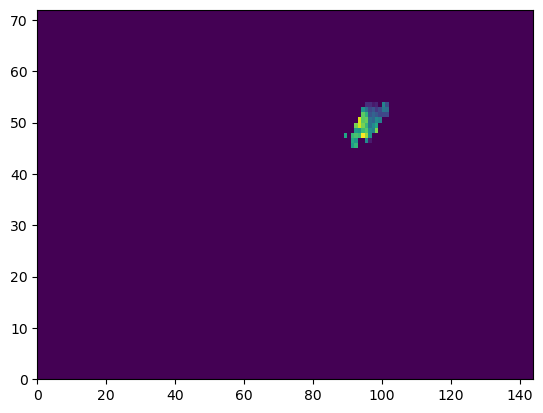

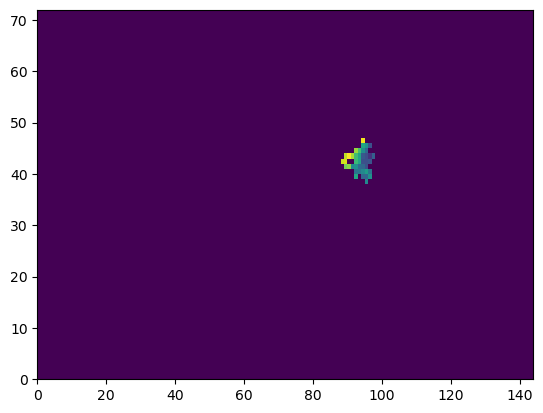

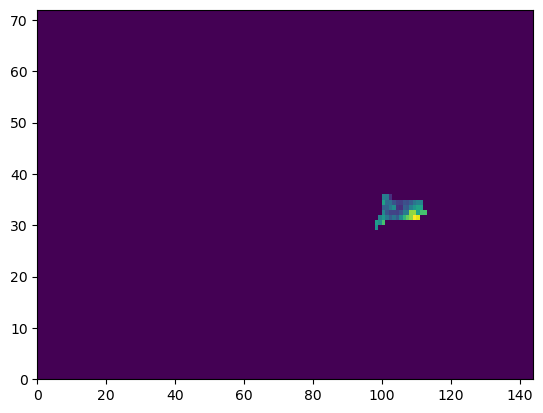

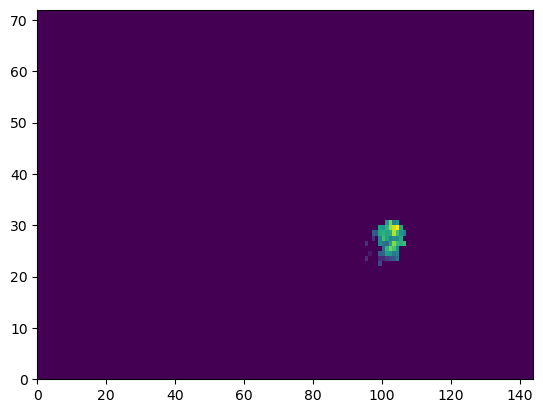

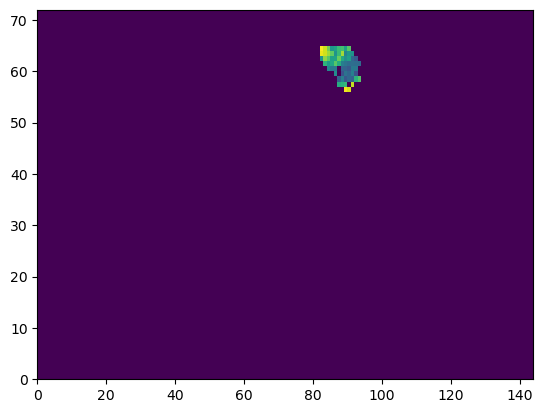

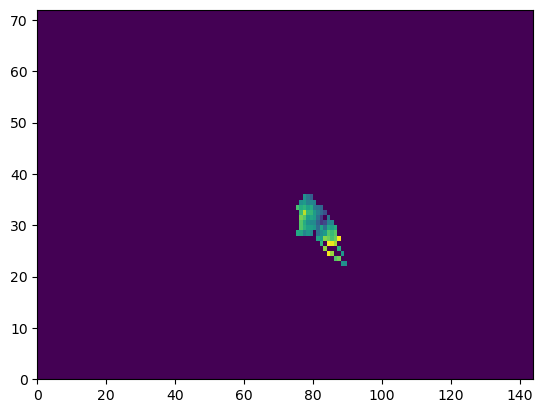

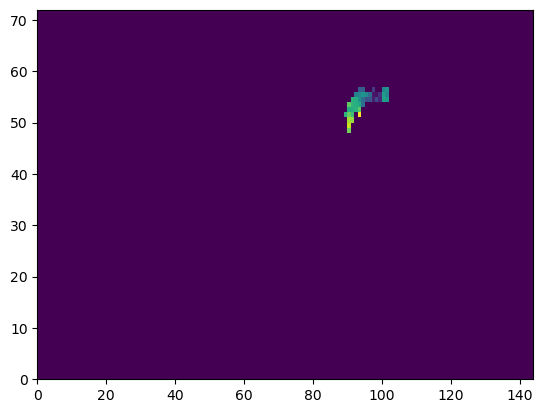

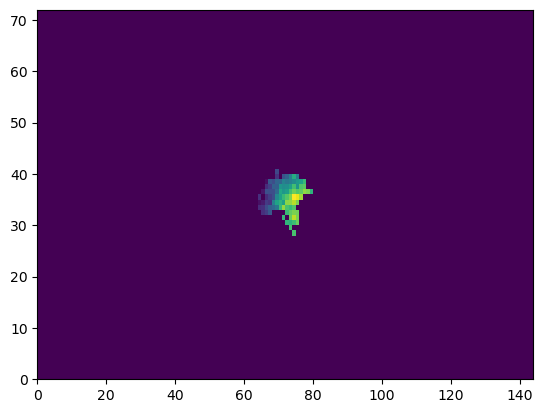

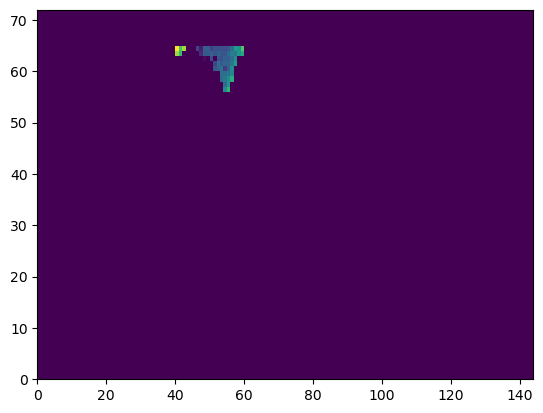

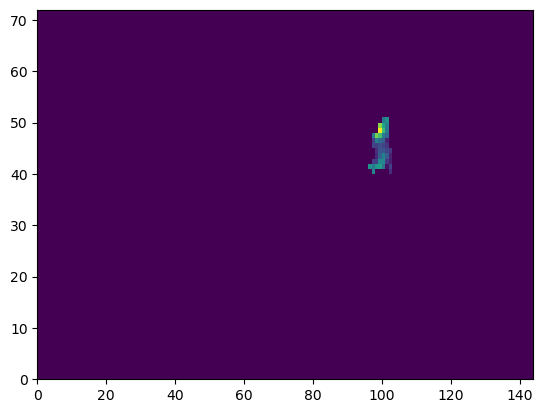

In [22]:
# create 2-d array for the index
county_weighted_index_rms = np.zeros((county_grid[0].shape[0], county_grid[0].shape[1]))

# loop thru all 24 counties/city
for r in range(24):
    
    # min-max scale each county/city:
    # RMS
    minmaxscaled_rms = minmaxscale(ds_rms.where(county_grid[r]==1, np.nan))
    minmaxscaled_rms = minmaxscaled_rms.where(~np.isnan(minmaxscaled_rms), 0.0)
    
    # quick vis
    plt.pcolormesh(minmaxscaled_rms); plt.show()
    
    county_weighted_index_rms = county_weighted_index_rms + (minmaxscaled_rms)

## Index Creation: Methodology

1. Normalize ZCTA population by ZCTA area. 

- We do this because some zip code areas are larger than others. This provides population density.

2. Regrid the normalized ZCTA population onto the RMS/event 5x5-km grid.

- This is done so that we can perform operations on multiple variables to generate an index.

3. Take the square root of normalized ZCTA population.

- Square root is taken in order to create a smoother distribution of population values.

4. Min-max scale the RMS/event frequency (by county).

- Min-max scaling [ (X -Xmin) / (Xmax - Xmin) ] is done because variables are on very different scales, with event frequency being comparatively much larger. We do this on a county basis so that we can find the relatively higher magnitudes at each county (each county gets one station).

5. Min-max scale the normalized ZCTA population (by county).


6. Multiply the min-max scaled RMS/event frequency and the min-max scaled square root normalized population.

## Step 1:

Normalize ZCTA population by ZCTA area.

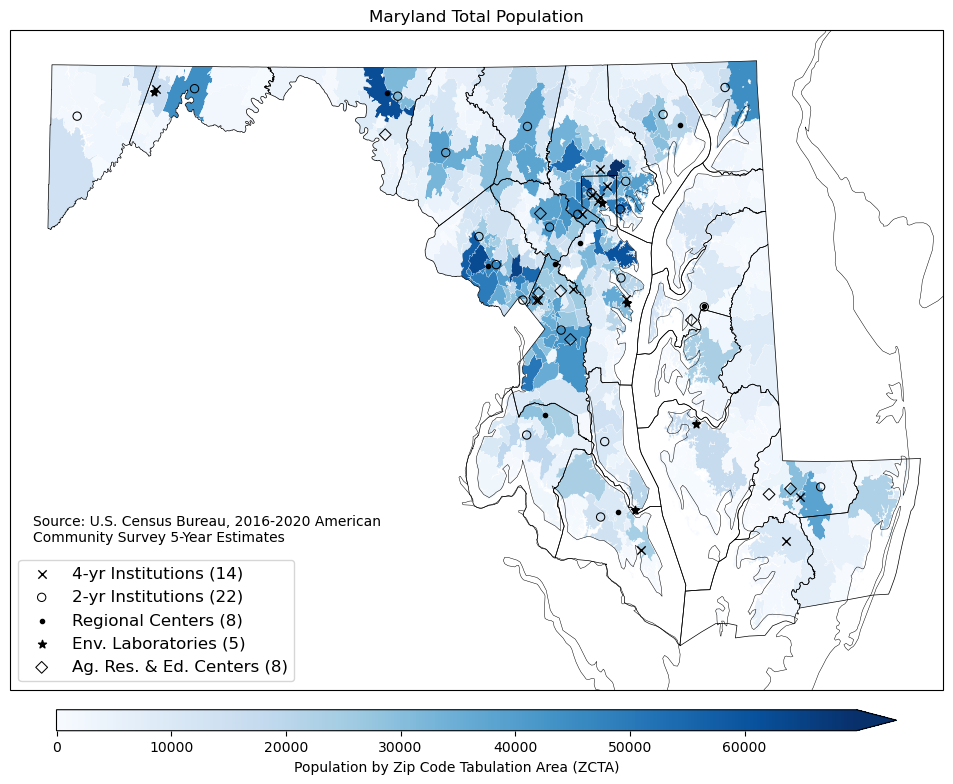

In [23]:
# population
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Total Population', fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# population and ZTCAs
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='POP100', cmap='Blues', 
                    legend=True, edgecolor='w', lw=0.15, figsize=(12,8),
                    legend_kwds={'label': 'Population by Zip Code Tabulation Area (ZCTA)', 
                                 "orientation": "horizontal",
                                 'shrink':0.7, 'pad':0.025, 'aspect':40, 'extend':'max'})

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)
    
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/pop_md.png', bbox_inches='tight', dpi=500)
plt.show()

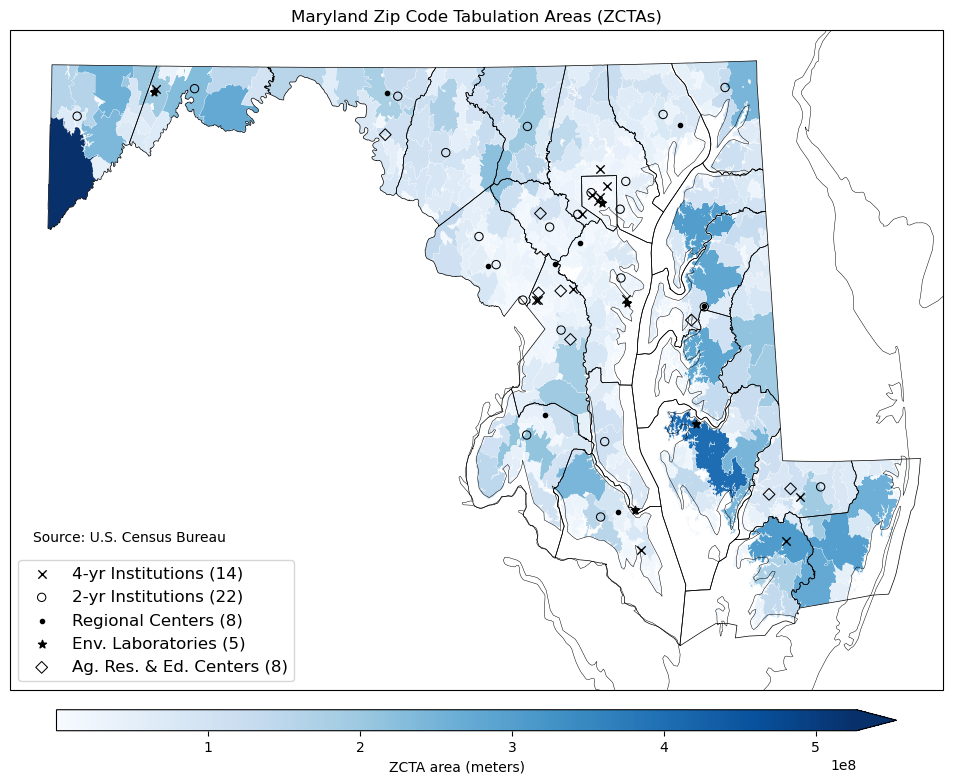

In [24]:
# land area (km)
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Zip Code Tabulation Areas (ZCTAs)', fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# population and ZTCAs
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='AREALAND', cmap='Blues', 
                    legend=True, edgecolor='w', lw=0.15, figsize=(12,8), 
                    legend_kwds={'label': 'ZCTA area (meters)', 
                                 "orientation": "horizontal",
                                 'shrink':0.7, 'pad':0.025, 'aspect':40, 'extend':'max'})

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)
    
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/area_md.png', bbox_inches='tight', dpi=500)
plt.show()

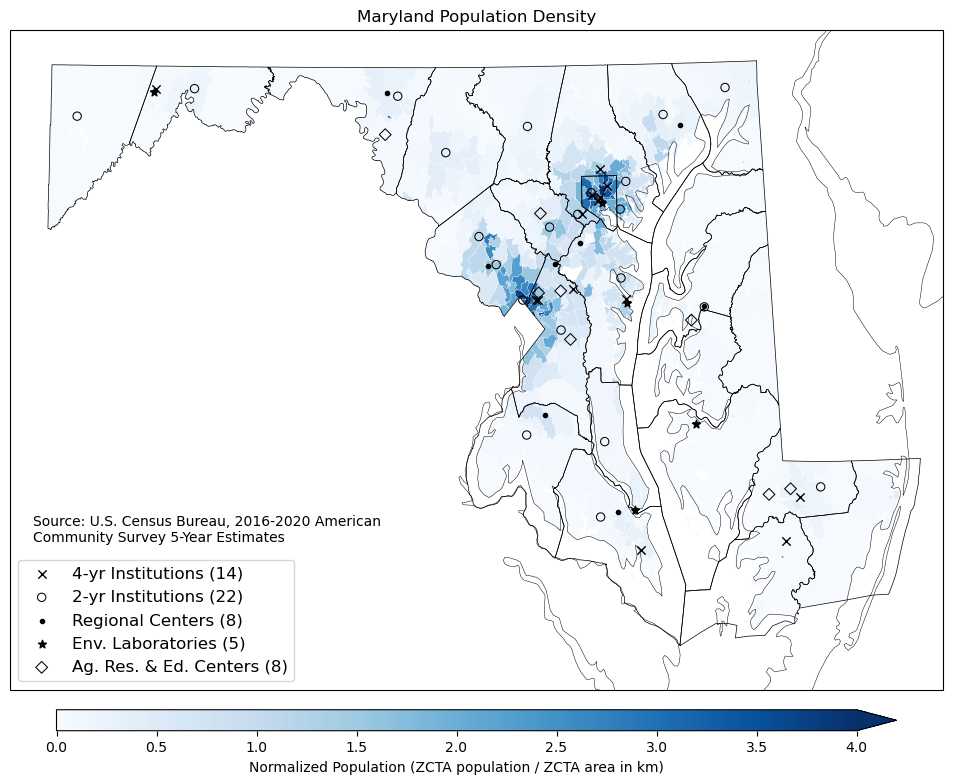

In [25]:
# population normalized by land area (km)
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Population Density', fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# population and ZTCAs
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='popnormbyarea', cmap='Blues', 
                    legend=True, edgecolor='w', lw=0.15, figsize=(12,8), vmin=0, vmax=4, 
                    legend_kwds={'label': 'Normalized Population (ZCTA population / ZCTA area in km)', 
                                 "orientation": "horizontal",
                                 'shrink':0.7, 'pad':0.025, 'aspect':40, 'extend':'max'})

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)
    
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/normpop_md.png', bbox_inches='tight', dpi=500)
plt.show()

## Step 2:

Regrid the normalized ZCTA population onto the RMS/event 5x5-km grid.

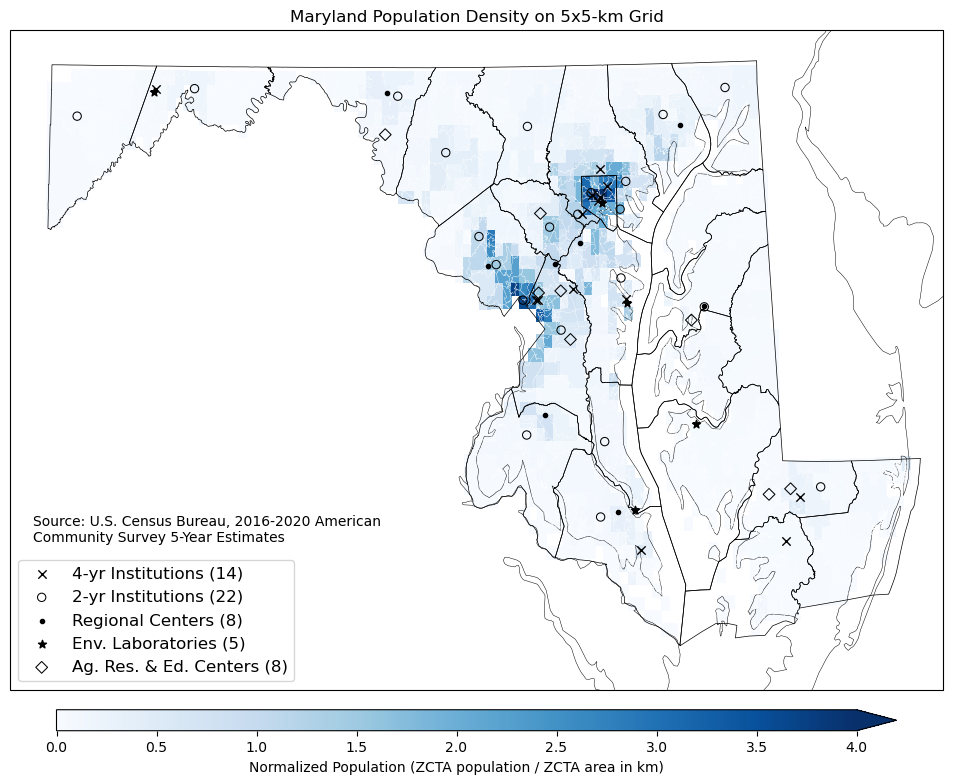

In [26]:
# regridded normpop
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Population Density on 5x5-km Grid', fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat, xr.where(md_state_mask==1, md_popnorm_grid, np.nan),
                   vmin=0, vmax=4, cmap='Blues',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40, extend='max')
cbar.set_label('Normalized Population (ZCTA population / ZCTA area in km)')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/normpop_grid_md.png', bbox_inches='tight', dpi=500)
plt.show()

## Step 3:

Take the square root of normalized ZCTA population.

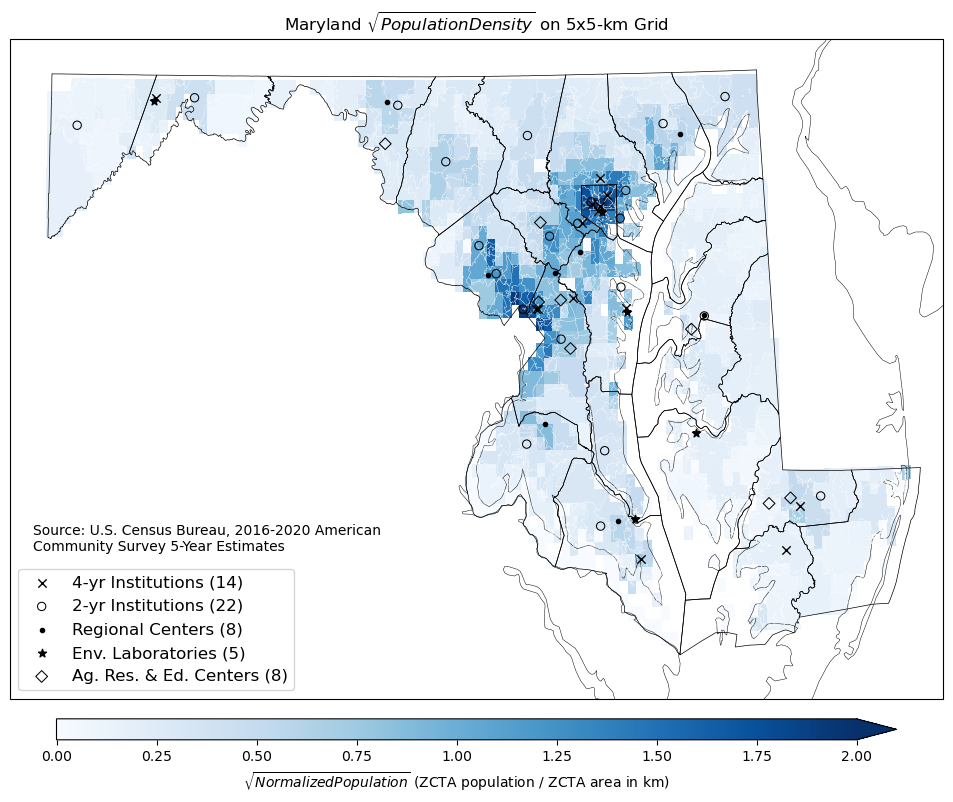

In [27]:
# normed pop sq root
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title(u'Maryland $\sqrt{Population Density}$ on 5x5-km Grid', fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat, xr.where(md_state_mask==1, md_popnorm_grid_sqrt, np.nan),
                   vmin=0, vmax=2, cmap='Blues',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40, extend='max')
cbar.set_label(u'$\sqrt{Normalized Population}$ (ZCTA population / ZCTA area in km)')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/normpop_sqrt_md.png', bbox_inches='tight', dpi=500)
plt.show()

## Step 4:

Min-max scale the RMS/event frequency (by county)

### event frequency

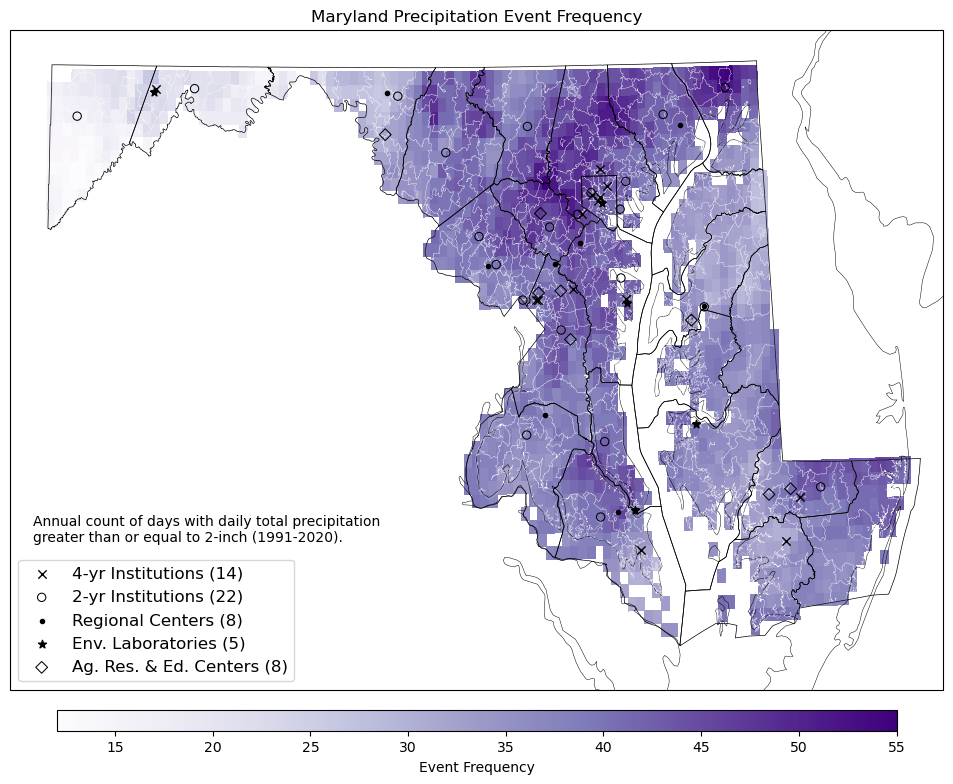

In [28]:
# event cnt
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Precipitation Event Frequency', fontsize=12)

ax.annotate(
    'Annual count of days with daily total precipitation \ngreater than or equal to 2-inch (1991-2020).',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat,
                   xr.where(~np.isnan(test_grid), 
                            xr.where(md_state_mask==1, ds_cnt.data, np.nan), np.nan),
                   cmap='Purples',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Event Frequency')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/eventcnt_md.png', bbox_inches='tight', dpi=500)
plt.show()

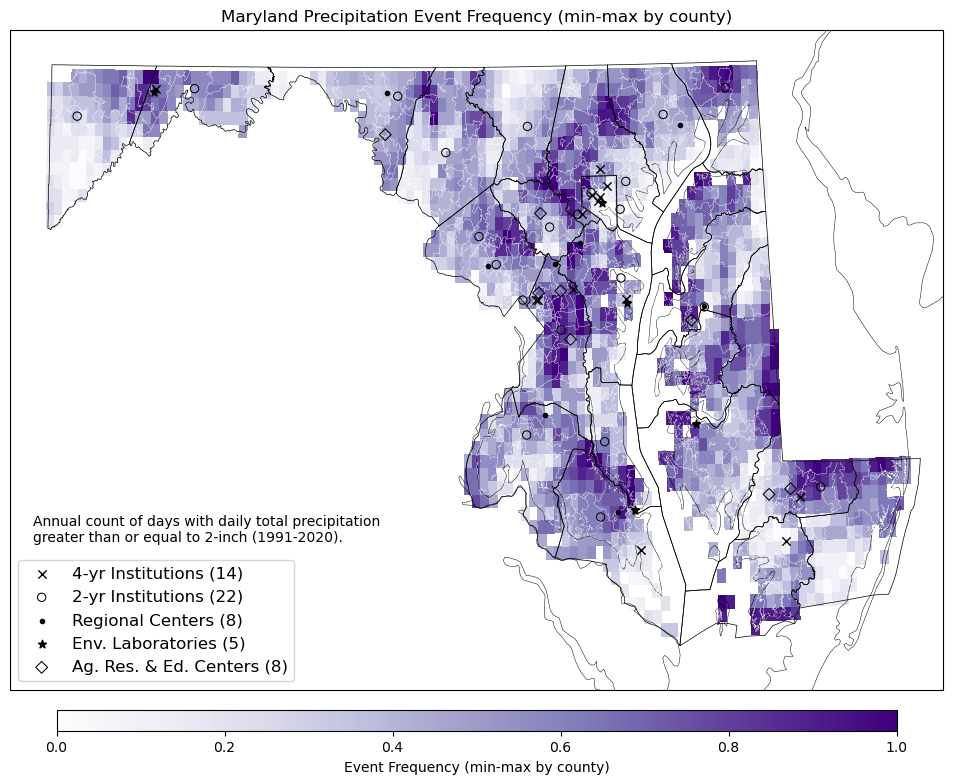

In [29]:
# event cnt minmax
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Precipitation Event Frequency (min-max by county)', fontsize=12)

ax.annotate(
    'Annual count of days with daily total precipitation \ngreater than or equal to 2-inch (1991-2020).',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat,
                   xr.where(~np.isnan(test_grid), 
                            xr.where(md_state_mask==1, county_weighted_index_cnt, np.nan), np.nan),
                   cmap='Purples',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Event Frequency (min-max by county)')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/eventcnt_minmax_md.png', bbox_inches='tight', dpi=500)
plt.show()

### event rms

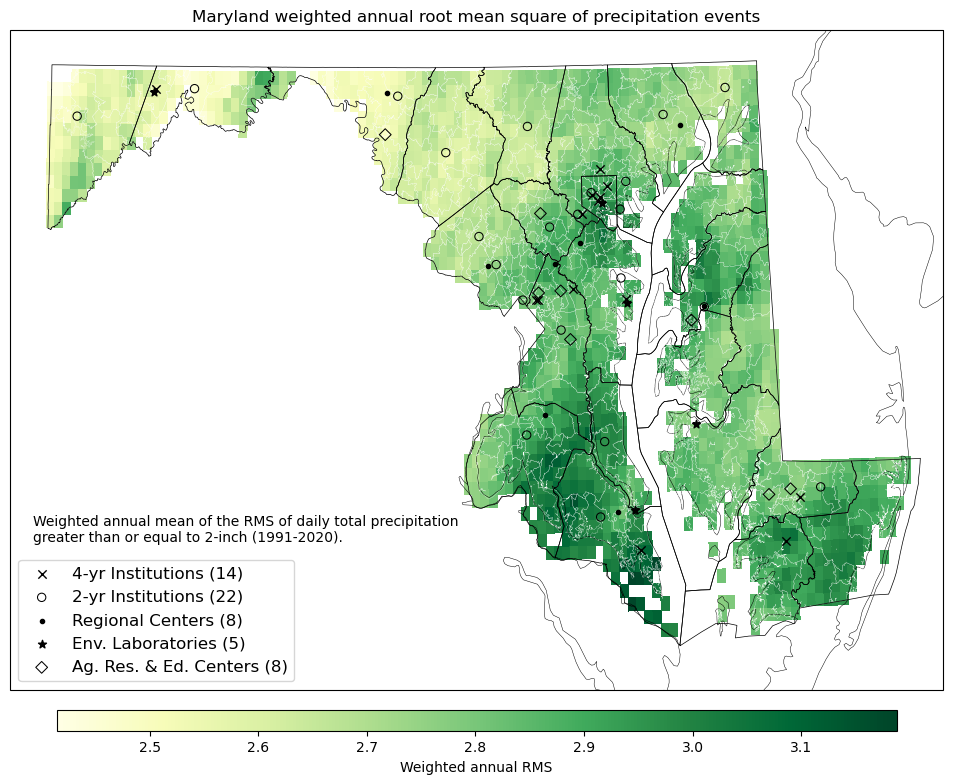

In [30]:
# rms
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland weighted annual root mean square of precipitation events', fontsize=12)

ax.annotate(
    'Weighted annual mean of the RMS of daily total precipitation \ngreater than or equal to 2-inch (1991-2020).',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat, 
                   xr.where(~np.isnan(test_grid), 
                            xr.where(md_state_mask==1, ds_rms, np.nan), np.nan),
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Weighted annual RMS')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/rms_md.png', bbox_inches='tight', dpi=500)
plt.show()

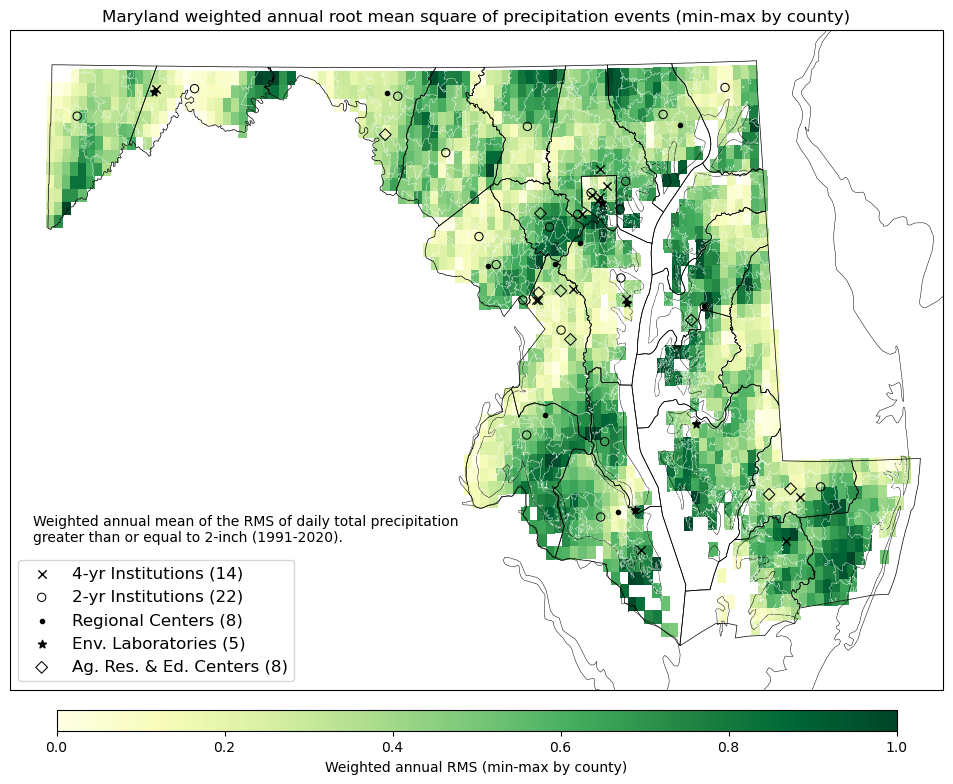

In [31]:
# rms minmax
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland weighted annual root mean square of precipitation events (min-max by county)', 
             fontsize=12)

ax.annotate(
    'Weighted annual mean of the RMS of daily total precipitation \ngreater than or equal to 2-inch (1991-2020).',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat, 
                   xr.where(~np.isnan(test_grid), 
                            xr.where(md_state_mask==1, county_weighted_index_rms, np.nan), np.nan),
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Weighted annual RMS (min-max by county)')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/rms_minmax_md.png', bbox_inches='tight', dpi=500)
plt.show()

## Step 5:

Min-max scale the normalized ZCTA population (by county)

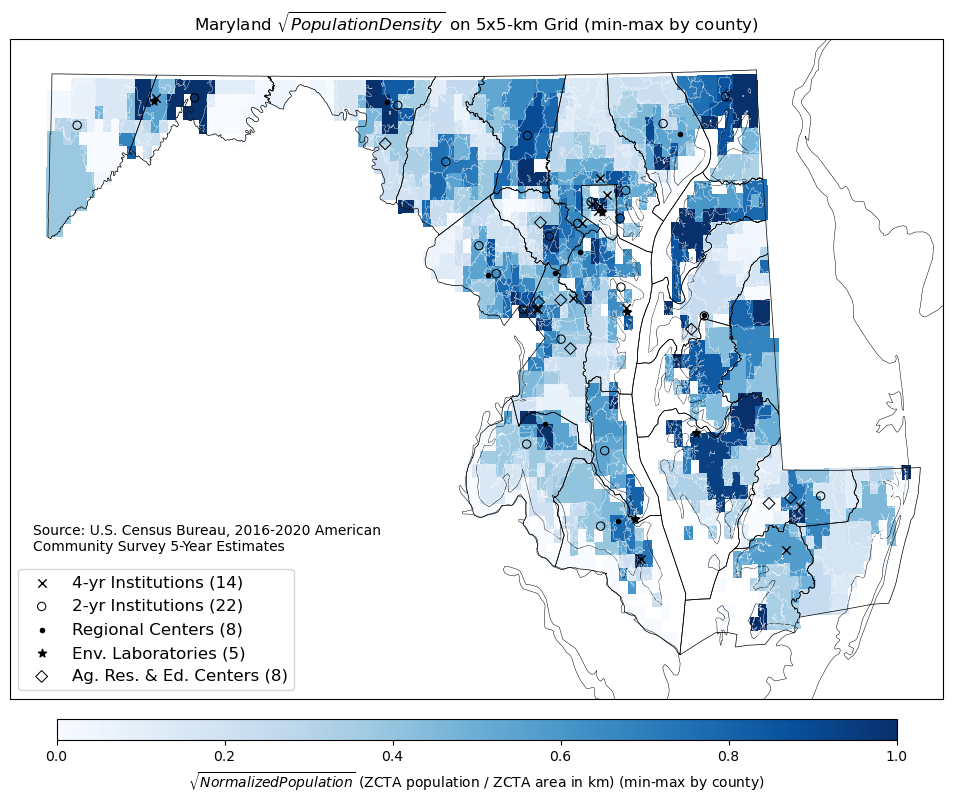

In [32]:
# normed pop
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title(u'Maryland $\sqrt{Population Density}$ on 5x5-km Grid (min-max by county)', fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat, 
                   xr.where(~np.isnan(test_grid), 
                            xr.where(md_state_mask==1, county_popnorm_grid_sqrt, np.nan), np.nan),
                   cmap='Blues',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label(u'$\sqrt{Normalized Population}$ (ZCTA population / ZCTA area in km) (min-max by county)')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/normpop_sqrt_minmax_md.png', bbox_inches='tight', dpi=500)
plt.show()

## Step 6:

Multiply the min-max scaled RMS/event frequency and the min-max scaled square root normalized population.

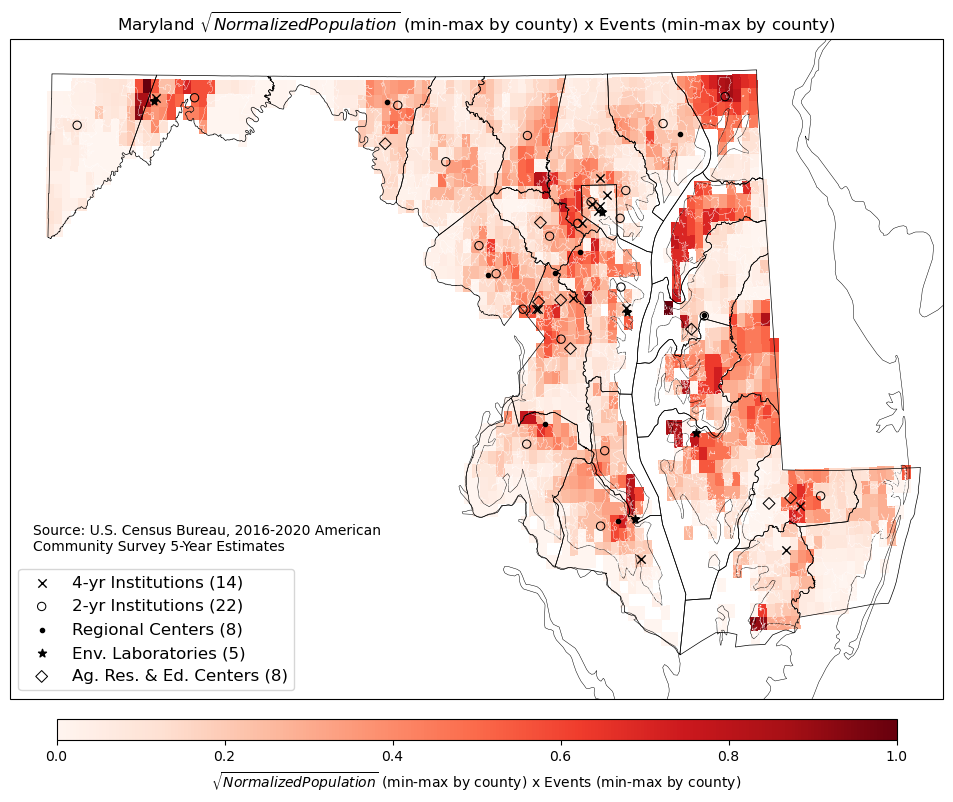

In [33]:
# sqrt pop * event freq
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title(
    u'Maryland $\sqrt{Normalized Population}$ (min-max by county) x Events (min-max by county)', 
    fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat, 
                   xr.where(
                       ~np.isnan(test_grid), 
                            xr.where(
                                md_state_mask==1, 
                                county_popnorm_grid_sqrt * county_weighted_index_cnt, 
                                np.nan), 
                            np.nan),
                   cmap='Reds',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label(u'$\sqrt{Normalized Population}$ (min-max by county) x Events (min-max by county)')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/index1_md.png', bbox_inches='tight', dpi=500)
plt.show()

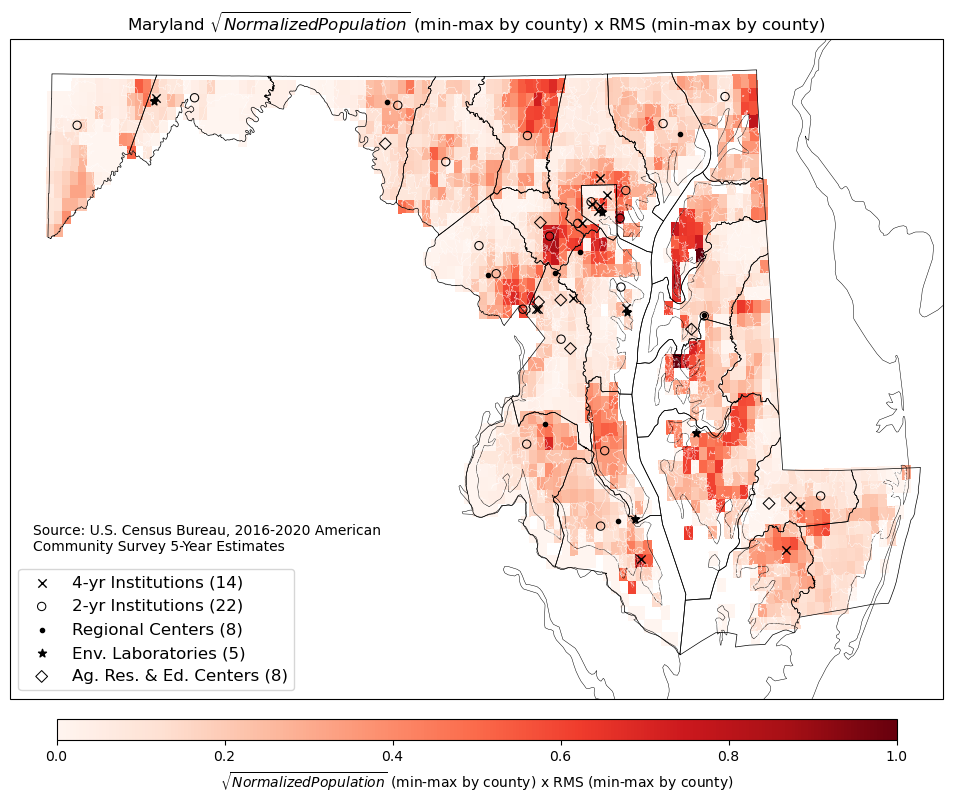

In [34]:
# normed pop
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title(
    u'Maryland $\sqrt{Normalized Population}$ (min-max by county) x RMS (min-max by county)', 
    fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat, 
                   xr.where(
                       ~np.isnan(test_grid), 
                            xr.where(md_state_mask==1, 
                                     county_popnorm_grid_sqrt * county_weighted_index_rms, 
                                     np.nan), 
                       np.nan),
                   cmap='Reds',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label(u'$\sqrt{Normalized Population}$ (min-max by county) x RMS (min-max by county)')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/index2_md.png', bbox_inches='tight', dpi=500)
plt.show()

# Additional figures

## other index versions

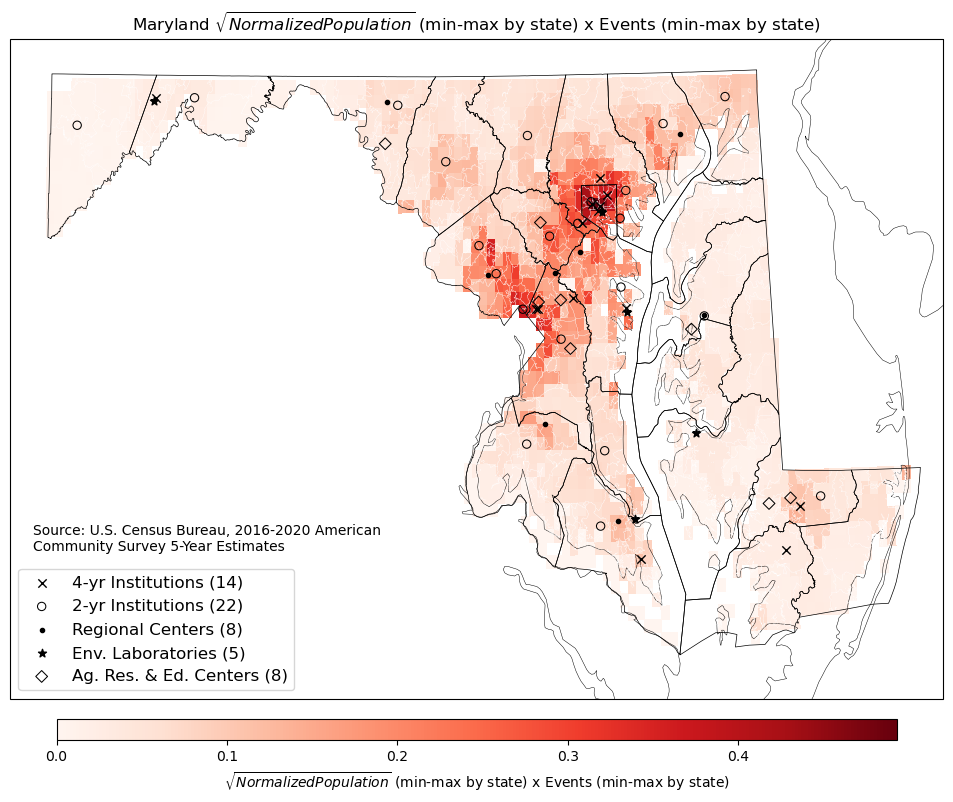

In [41]:
# sqrt pop * event freq
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title(
    u'Maryland $\sqrt{Normalized Population}$ (min-max by state) x Events (min-max by state)', 
    fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat, 
                   xr.where(
                       ~np.isnan(test_grid), 
                            xr.where(
                                md_state_mask==1, 
                                minmaxscale(md_popnorm_grid_sqrt) * minmaxscale(ds_cnt), 
                                np.nan), 
                            np.nan),
                   cmap='Reds',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label(u'$\sqrt{Normalized Population}$ (min-max by state) x Events (min-max by state)')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/index3_md.png', bbox_inches='tight', dpi=500)
plt.show()

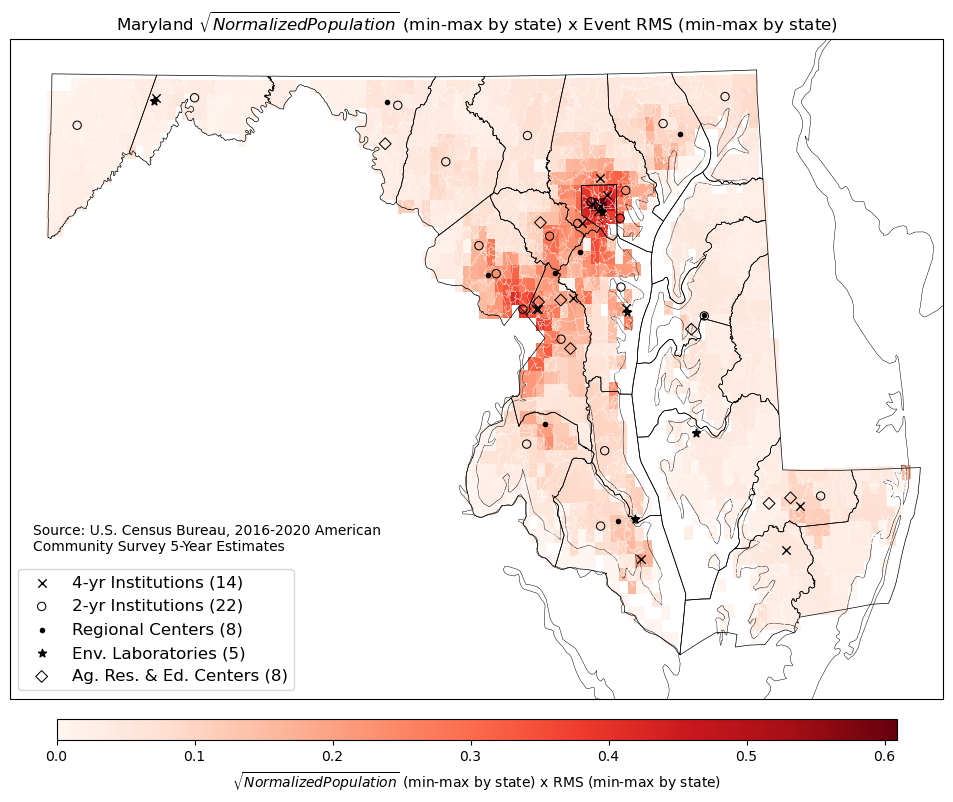

In [40]:
# sqrt pop * event freq
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title(
    u'Maryland $\sqrt{Normalized Population}$ (min-max by state) x Event RMS (min-max by state)', 
    fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# event count
pc = ax.pcolormesh(ds_cnt.lon, ds_cnt.lat, 
                   xr.where(
                       ~np.isnan(test_grid), 
                            xr.where(
                                md_state_mask==1, 
                                minmaxscale(md_popnorm_grid_sqrt) * minmaxscale(ds_rms), 
                                np.nan), 
                            np.nan),
                   cmap='Reds',
                   transform=ccrs.PlateCarree(), zorder=10)
# colorbar 
cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label(u'$\sqrt{Normalized Population}$ (min-max by state) x RMS (min-max by state)')

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)

# ztcas
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=False, facecolor='none', edgecolor='w', lw=0.15, zorder=100)
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/index4_md.png', bbox_inches='tight', dpi=500)
plt.show()

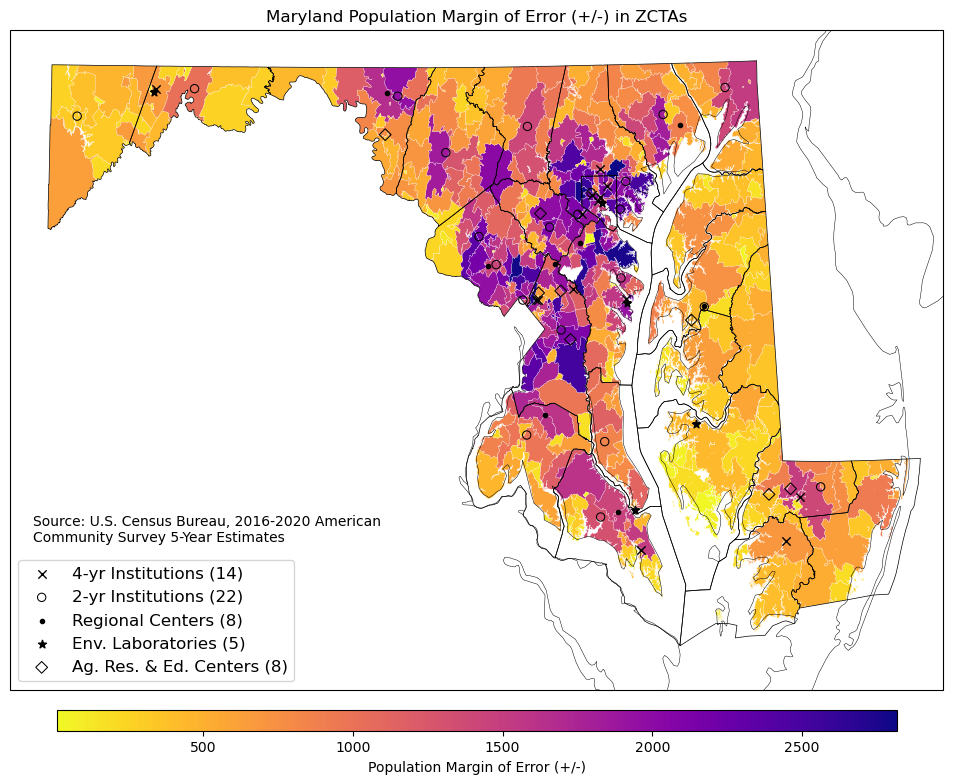

In [39]:
# population margin of error
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Maryland Population Margin of Error (+/-) in ZCTAs', fontsize=12)

ax.annotate(
    'Source: U.S. Census Bureau, 2016-2020 American \nCommunity Survey 5-Year Estimates',
    xy=(0.025, 0.225), xycoords='axes fraction', fontsize=10)

# population and ZTCAs
md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='newpop_merr', cmap='plasma_r', 
                    legend=True, edgecolor='w', lw=0.15, figsize=(12,8),
                    legend_kwds={'label': 'Population Margin of Error (+/-)', 
                                 "orientation": "horizontal",
                                 'shrink':0.7, 'pad':0.025, 'aspect':40})

# coastlines
ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=100)
    
# counties
md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 legend=False, facecolor='none', edgecolor='k', lw=0.5, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

# possible public locs
for i, j in zip(md_pb4yr['longitude'].values,
                md_pb4yr['latitude'].values):
    l0 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k', lw=1.)
    
for i, j in zip(md_pb2yr['longitude'].values,
                md_pb2yr['latitude'].values):
    l1 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='o', edgecolor='k', facecolor='none', lw=0.75)
    
for i, j in zip(md_regio['longitude'].values,
                md_regio['latitude'].values):
    l2 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='.', color='k')
    
for i, j in zip(md_envlb['longitude'].values,
                md_envlb['latitude'].values):
    l3 = ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='*', color='k')
    
for i, j in zip(md_agres['lon'].values,
                md_agres['lat'].values):
    l4 = ax.scatter(
        i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='D', edgecolor='k', facecolor='none', lw=0.75)
    
ax.legend([l0, l1, l2, l3, l4],
          [f'4-yr Institutions ({len(md_pb4yr)})',
           f'2-yr Institutions ({len(md_pb2yr)})',
           f'Regional Centers ({len(md_regio)})',
           f'Env. Laboratories ({len(md_envlb)})',
           f'Ag. Res. & Ed. Centers ({len(md_agres)})'], 
          fancybox=True, fontsize=12, loc='lower left')

plt.savefig('/Users/molina/Desktop/popmerr_md.png', bbox_inches='tight', dpi=500)
plt.show()